
# To run this notebook 

1.Create a directory (such as /home/username/mozi/jupyter in the below example) and put the notebook in it.

2.Put needed the needed data files into the directory, extracting from embeddings.tgz in this repository:

opencog_deps,mosesDoseNoFeature2Gene.csv,scV1kg26noDose.csv

3.Extract the following files from the mozi data site, and place them in the directory as well. The exact dates could change:

https://mozi.ai/datasets/gene-level-dataset_2020-04-03.tar.gz :

GO_2020-04-01.scm, GO_annotation_gene-level_2020-04-01.scm ,Go-Plus_2020-04-01.scm,NCBI2Reactome_PE_Pathway.txt_2020-04-01.scm,reactome_2020-04-01.scm,smpdb_gene_2020-04-03.scm 

https://mozi.ai/datasets/string_dataset_2020-04-01.tar.gz :

string_ggi_2020-03-31.scm

4.Call the command (replacing the directory with yours) :

docker run -p 8888:8888 -v /home/username/mozi/jupyter:/home/opencog -e mem_size=30000000000  xabush/opencog-jupyter:moses


In [1]:
import sys
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install graphviz

     |████████████████████████████████| 24.2MB 106kB/s  eta 0:00:01    |████████████████▉               | 12.7MB 4.7MB/s eta 0:00:03
     |████████████████████████████████| 26.1MB 95kB/s s eta 0:00:01   |███████████████████▍            | 15.8MB 14.7MB/s eta 0:00:01
     |████████████████████████████████| 20.2MB 126kB/s eta 0:00:011
     |████████████████████████████████| 112kB 12.3MB/s eta 0:00:01
     |████████████████████████████████| 1.4MB 6.7MB/s eta 0:00:01
     |████████████████████████████████| 133kB 10.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 2.3MB/s  eta 0:00:01
     |████████████████████████████████| 6.2MB 42.0MB/s eta 0:00:01
     |████████████████████████████████| 71kB 310kB/s  eta 0:00:01
     |████████████████████████████████| 143kB 43.0MB/s eta 0:00:01
     |████████████████████████████████| 163kB 16.4MB/s eta 0:00:01
     |████████████████████████████████| 133kB 15.9MB/s eta 0:00:01
     |████████████████████████████████| 61kB 257kB/s eta 0:00:011


     |████████████████████████████████| 10.0MB 7.0MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 109.8MB 24kB/s  eta 0:00:01     |██████▏                         | 21.2MB 12.1MB/s eta 0:00:08     |████████████████▏               | 55.3MB 16.5MB/s eta 0:00:04��▋       | 84.3MB 7.4MB/s eta 0:00:04     |████████████████████████████▎   | 97.0MB 27.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%cd /home/opencog

/home/opencog


In [3]:
from opencog.atomspace import AtomSpace, types
from opencog.scheme_wrapper import scheme_eval
from opencog.type_constructors import *
from opencog.atomspace import get_refreshed_types, get_type, get_type_name

In [4]:
atomspace = AtomSpace()

In [5]:
#deps= "/home/opencog/opencog_deps"
#sample_dataset = "/opt/sample_dataset.scm"
#deps= "opencog_deps"
#sample_dataset = "sample_dataset.scm"

#load the opencog_deps file which has the modules necessary to make the pattern matching functions run
#scheme_eval(atomspace, '(primitive-load "{}")'.format(deps))

# JJJ
scheme_eval(atomspace, "(use-modules (ice-9 readline))")
scheme_eval(atomspace, "(activate-readline)")
scheme_eval(atomspace, "(debug-enable 'backtrace)")
scheme_eval(atomspace, "(read-enable 'positions)")
scheme_eval(atomspace, "(use-modules (opencog))")
scheme_eval(atomspace, "(use-modules (opencog exec))")
scheme_eval(atomspace, "(use-modules (opencog bioscience))")
scheme_eval(atomspace, "(use-modules (rnrs base))")
scheme_eval(atomspace, "(use-modules (rnrs exceptions))")
scheme_eval(atomspace, "(use-modules (ice-9 textual-ports))")
scheme_eval(atomspace, "(use-modules (ice-9 regex))")
scheme_eval(atomspace, "(use-modules (srfi srfi-98))")
scheme_eval(atomspace, "(use-modules (ice-9 match))")
scheme_eval(atomspace, "(use-modules (ice-9 threads))")
scheme_eval(atomspace, "(use-modules (ice-9 ftw))")
scheme_eval(atomspace, "(use-modules (srfi srfi-1))")

b'\n'

In [6]:

scheme_eval(atomspace, '(primitive-load "{}")'.format("reasoning-bio-as-xp/kbs/string_ggi_2020-03-31.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("reasoning-bio-as-xp/kbs/GO_2020-04-01.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("reasoning-bio-as-xp/kbs/Go-Plus.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("reasoning-bio-as-xp/kbs/GO_annotation_gene-level_2020-04-01.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("reasoning-bio-as-xp/kbs/NCBI2Reactome_PE_Pathway.txt_2020-04-01.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("reasoning-bio-as-xp/kbs/reactome_2020-04-01.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("reasoning-bio-as-xp/kbs/smpdb_gene_2020-04-03.scm"))


#verify the atoms are loaded

print("after datasets:" +scheme_eval(atomspace, "(count-all)").decode("utf-8"))

after datasets:3369333



In [7]:
#specify the default atomspace to use for running queries
set_default_atomspace(atomspace)

In [8]:
#we need to refresh the type dict so that it contains the newly added types [GeneNode, MoleculeNode]
types = get_refreshed_types()

In [9]:
import copy
def find_deepwalk_node_type(node): 
    deepwalk_node_type = None
    node_defs ={ 
            #take the first that begins with the string"
            "ConceptNode":[("R-HSA","rhsapathway"), ("SMP","smppathway"), ("GO:","geneontologyterm")],
            "PredicateNode":[("has_location","location")],
            "GeneNode":[("","gene")]
    }
    #print("node.type_name")
    #print(node.type_name)
    if (node.type_name in node_defs):
        prefix_list =copy.deepcopy(node_defs[node.type_name])
        found = False
        while not found and len(prefix_list)> 0:
            prefix_tuple = prefix_list.pop(0)
            #print ("prefix_tuple")
            #print (prefix_tuple)
            if prefix_tuple[0] == "" or node.name.startswith(prefix_tuple[0]):
                found == True
                deepwalk_node_type = prefix_tuple[1]
                
    return deepwalk_node_type

In [10]:
from opencog.bindlink import execute_atom

def construct_eval_set_query(predicate, node, other_type=None):
    '''
    Note: this function is returning the Evalutaion Links instead of the grounded node because 
    the links have the truth values
    '''
    if other_type is None:      
        bind_atom = \
            GetLink(
                VariableNode("$g"),
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                 EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                )
            )
    else:
        bind_atom = \
            BindLink(
                TypedVariableLink(VariableNode("$g"), TypeNode(other_type)),
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                )
            )
        
    result = execute_atom(atomspace, bind_atom)
    #print(result)
    return result.out

In [11]:
from opencog.bindlink import execute_atom

def construct_eval_query(predicate, node, other_type=None):
    if other_type is None:      
        bind_atom = \
            BindLink(
                VariableNode("$g"),
                EvaluationLink(
                    PredicateNode(predicate),
                    ListLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                VariableNode("$g")
            )
    else:
        bind_atom = \
            BindLink(
                TypedVariableLink(VariableNode("$g"), TypeNode(other_type)),
                EvaluationLink(
                    PredicateNode(predicate),
                    ListLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                VariableNode("$g")
            )
        
    result = execute_atom(atomspace, bind_atom)
    return result.out


In [12]:
from opencog.bindlink import execute_atom
def construct_member_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 MemberLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
                 )
    
    result = execute_atom(atomspace, member_atom)
    return result.out

In [13]:
from opencog.bindlink import execute_atom
def construct_inheritance_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 InheritanceLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
                 )
    
    result = execute_atom(atomspace, member_atom)
    return result.out

In [14]:
from opencog.bindlink import execute_atom
def construct_subset_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 SubsetLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
                 )
    
    result = execute_atom(atomspace, member_atom)
    return result.out

In [15]:
def construct_context_query(gene):
    query_atom = \
        BindLink(
            VariableList(
                TypedVariableLink(VariableNode("$p"), TypeNode("ConceptNode")),
                TypedVariableLink(VariableNode("$q"), TypeNode("ConceptNode"))
            ),
    
            ContextLink(
                
                MemberLink (
                    gene,
                    VariableNode ("$p")
                ),

                EvaluationLink (
                     PredicateNode ("has_location"),
                     ListLink(
                        gene,
                        VariableNode ("$q")
                     )
                )

            ),
       
        
            ListLink(
                VariableNode("$p"),
                VariableNode("$q")
            )
        )
    result = execute_atom(atomspace, query_atom)
    return result.out

In [16]:
linkset = {"inhibits", "is-inhibited-by", "ptmod", "is-ptmoded-by", "expresses","is-expressed-by", 
           "activates", "is-activated-by", "catalyzes", "is-catalyzed-by", "binds-with", "reacts-with", 
            "in-smp-pathway", "has-smp-pathway-member", "in-gene-ontology",
           "has-gene-ontology-member", 'is-in',  'in-context-of', 'is-context-where', 
           'has', "inherits-pathway", "pathway-inherited-by", 
           "inherits-geneontologyterm", "geneontologyterm-inherited-by", "positively-regulates",
           "is-positively-regulated-by", "negatively-regulates", "is-negatively-regulated-by",
           'has-variant','is-variant-of',"has-person-member", "is-person-member-of", 
           "superc-has-variant", "is-variant-of-superc",
           "normal-has-variant", "is-variant-of-normal"
          }
geneset = set()
rhsapathwayset = set()
smppathwayset= set()
geneontologytermset = set()
locationset = set()

for node in atomspace.get_atoms_by_type(types.Node):
    deepwalk_type = find_deepwalk_node_type(node)
    
    if deepwalk_type and deepwalk_type =="gene":
        geneset.add(node.name)
    if deepwalk_type and deepwalk_type =="rhsapathway":
        rhsapathwayset.add(node.name)
    if deepwalk_type and deepwalk_type =="smppathway":
        smppathwayset.add(node.name)
    if deepwalk_type and deepwalk_type =="geneontologyterm":
        geneontologytermset.add(node.name)
    if deepwalk_type and deepwalk_type =="location":
        locationset.add(node.name)
genelist = list(geneset)
print(len(genelist))
geneontologytermlist =list(geneontologytermset)
len(geneontologytermlist)

28277


44678

In [17]:
import pandas as pd

biomapdf = pd.read_csv("reasoning-bio-as-xp/csv/mosesDoseNoFeature2Gene.csv")
centdf = pd.read_csv("reasoning-bio-as-xp/csv/scV1kg26noDose.csv")
print(len(biomapdf))

genes=set(biomapdf['Name'])
print(len (genes))

intersection = genes.intersection(geneset)
print(len(intersection))

current_map =biomapdf[biomapdf['Name'].isin(intersection)]
print(len(current_map))

51877
1843
934
37741


In [18]:
phrases =set()
truth_values ={}
halfphrases = set()
proteinset = set()
for index, row in current_map.iterrows():
    phrases.add((row['Name'].strip(),'has-variant',row['feature'].strip()))
    halfphrases.add((row['Name'].strip(),'has-variant',row['feature'].strip()))
    phrases.add((row['feature'].strip(),'is-variant-of',row['Name'].strip()))
    proteinset.add(row['feature'].strip())


In [19]:
supercpersonset =set()
normalpersonset = set()
persontypeset = set()
persontypeset.add('normal')
persontypeset.add('superc')
isa_supercenturian =[]
for (columnName, columnData) in centdf.iteritems():
    if columnName== 'case':
        isa_supercenturian = columnData.values
    else:
        for index,has_expressed in enumerate(columnData.values):
            name =""
            if isa_supercenturian[index]==1:
                name = "superc"+str(index)
                phrases.add(("superc","has-person-member",name))
                halfphrases.add(("superc","has-person-member",name))
                phrases.add((name, "is-person-member-of", "superc"))
                supercpersonset.add(name)
                if has_expressed == 1:
                    phrases.add((name,"superc-has-variant",columnName.strip()))
                    halfphrases.add((name,"superc-has-variant",columnName.strip()))
                    phrases.add((columnName.strip(), "is-variant-of-superc", name))
            else:
                name = "normal"+str(index)
                phrases.add(("normal","has-person-member",name))
                halfphrases.add(("normal","has-person-member",name))
                phrases.add((name, "is-person-member-of", "normal"))
                normalpersonset.add(name)
                if has_expressed == 1:
                    phrases.add((name,"normal-has-variant",columnName.strip()))
                    halfphrases.add((name,"normal-has-variant",columnName.strip()))
                    phrases.add((columnName.strip(), "is-variant-of-normal", name))
supercpersonlist = list(supercpersonset)

In [20]:
def add_gene_triplet(node,name,verb,reverse):
    result3 = construct_eval_set_query(name, node, other_type='GeneNode')
    if result3:
        for evalLink in result3:
            tv = None
            if hasattr(evalLink,"tv"):
                strength = evalLink.tv.mean
                confidence = evalLink.tv.confidence
                tv = (strength,confidence)
                #print(tv)
            node2 = evalLink.out[1].out[0]
            deepwalk_type2=find_deepwalk_node_type(node2)
            #print(deepwalk_type2)
            if deepwalk_type2 =="gene":
                tup = (node.name.strip() ,verb, node2.name.strip() )
                reverse_tup = (node2.name.strip() ,reverse, node.name.strip() )
                if (node2.name.strip(),node.name.strip()) not in existingTuples:
                    halfphrases.add(tup)
                    existingTuples.add((node.name.strip(),node2.name.strip()))
                phrases.add(tup)
                phrases.add(reverse_tup)
                if tv is not None:
                    truth_values [tup]=tv
                    truth_values[reverse_tup]=tv


In [21]:
existingTuples = set()

for node in atomspace.get_atoms_by_type(types.Node):
    #print('node.name')
    #print(node.name)
    deepwalk_type = find_deepwalk_node_type(node)
    if deepwalk_type and deepwalk_type =="gene":
        result = construct_member_query(node)
        if result:
            for node2 in result:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="smppathway":
                    halfphrases.add((node.name.strip() ,"in-smp-pathway", node2.name.strip() ))
                    phrases.add((node.name.strip() ,"in-smp-pathway", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"has-smp-pathway-member", node.name.strip() ))
                elif deepwalk_type2 =="geneontologyterm":
                    halfphrases.add((node.name.strip() ,"in-gene-ontology", node2.name.strip() ))
                    phrases.add((node.name.strip() ,"in-gene-ontology", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"has-gene-ontology-member", node.name.strip() ))
        result2 = construct_context_query(node)
        if result2:
            for node2 in result2:
                halfphrases.add((node.name.strip(), 'is-in', node2.out[1].name.strip(), 'in-context-of', node2.out[0].name.strip()))
                
                phrases.add((node.name.strip(), 'is-in', node2.out[1].name.strip(), 'in-context-of', node2.out[0].name.strip()))
                phrases.add(( node2.out[0].name.strip(), 'is-context-where', node2.out[1].name.strip(), 'has', node.name.strip()))
       
        #result3 = construct_eval_query('interacts_with', node, other_type='GeneNode')
        add_gene_triplet(node,'inhibition','inhibits','is-inhibited-by')
        add_gene_triplet(node,'ptmod','ptmod','is-ptmoded-by')
        add_gene_triplet(node,'expression','expresses','is-expressed-by')
        add_gene_triplet(node,'activation','activates','is-activated-by')
        add_gene_triplet(node,'catalysis','catalyzes','is-catalyzed-by')
        add_gene_triplet(node,'binding','binds-with','binds-with')
        add_gene_triplet(node,'reaction','reacts-with','reacts-with')
    
    elif deepwalk_type and deepwalk_type =="rhsapathway":
        result10 = construct_inheritance_query(node)
        if result10:
            for node2 in result10:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="rhsapathway":
                    halfphrases.add((node.name.strip() ,"inherits-pathway", node2.name.strip() ))
                    
                    phrases.add((node.name.strip() ,"inherits-pathway", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"pathway-inherited-by", node.name.strip() ))
    elif deepwalk_type and deepwalk_type =="geneontologyterm":
        result11 = construct_inheritance_query(node)
        if result11:
            for node2 in result11:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="geneontologyterm":
                    halfphrases.add((node.name.strip() ,"inherits-geneontologyterm", node2.name.strip() ))
                    
                    phrases.add((node.name.strip() ,"inherits-geneontologyterm", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"geneontologyterm-inherited-by", node.name.strip() ))
        result12 = construct_eval_query('GO_positively_regulates', node, other_type='ConceptNode')
        if result12:
            for node2 in result12:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="geneontologyterm":
                    halfphrases.add((node.name.strip() ,"positively-regulates", node2.name.strip() ))
                    
                    phrases.add((node.name.strip() ,"positively-regulates", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"is-positively-regulated-by", node.name.strip() ))
        result13 = construct_eval_query('GO_negatively_regulates', node, other_type='ConceptNode')
        if result13:
            for node2 in result13:
                deepwalk_type2=find_deepwalk_node_type(node2)
                if deepwalk_type2 =="geneontologyterm":
                    halfphrases.add((node.name.strip() ,"negatively-regulates", node2.name.strip() ))
                    
                    phrases.add((node.name.strip() ,"negatively-regulates", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"is-negatively-regulated-by", node.name.strip() ))

In [22]:
includedNodesSet = set()
includedRelationsSet=set()
includedTripletsSet= set()
for tup in halfphrases:
    if len(tup)> 1:
        includedNodesSet.add(tup[0])
        includedRelationsSet.add(tup[1])
        includedNodesSet.add(tup[2])
    if len(tup)> 3:
        includedRelationsSet.add(tup[3])
        includedNodesSet.add(tup[4])
    if len(tup)== 3:
        includedTripletsSet.add(tup)
    elif len(tup)==5:
        splittup = tuple([tup[0],tup[1],tup[2]])
        includedTripletsSet.add(splittup)
        splittup = tuple([tup[2],tup[3],tup[4]])
        includedTripletsSet.add(splittup)
        

In [23]:
percent_test=10
percent_valid=10
num_test = int(len(phrases) * 0.01 * percent_test)
num_valid_and_test = int(len(phrases) * 0.01 * percent_valid) + num_test

file = open("entities.dict","w") 
for i,node in enumerate(includedNodesSet):
    file.write("{0}\t{1}\n".format(i,node)) 
file.close() 
 
file = open("relations.dict","w") 
for i,rel in enumerate(includedRelationsSet):
    file.write("{0}\t{1}\n".format(i,rel)) 
file.close() 

file1 = open("test.txt","w") 
file2 = open("valid.txt","w") 
file3 = open("train.txt","w") 
for i,t in enumerate(includedTripletsSet):
    if i < num_test:
        file1.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    elif i < num_valid_and_test:
        file2.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    else:
        file3.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    
file1.close()
file2.close()    
file3.close() 

In [24]:
len(phrases)

6146148

In [25]:
phrases

{('normal96', 'normal-has-variant', '9:37434371_G/A'),
 ('X:53574983_A/G', 'is-variant-of-normal', 'normal175'),
 ('X:70474850_G/C', 'is-variant-of-normal', 'normal113'),
 ('normal310', 'normal-has-variant', 'MT:11002_A/G'),
 ('normal387', 'normal-has-variant', '6:159065758_C/G'),
 ('normal390', 'normal-has-variant', '3:136668412_T/C'),
 ('X:153061229_T/G', 'is-variant-of-normal', 'normal405'),
 ('normal215', 'normal-has-variant', '6:2667689_T/G'),
 ('1:241793186_C/G', 'is-variant-of-normal', 'normal227'),
 ('4:68620957_T/C', 'is-variant-of-normal', 'normal28'),
 ('MT:14140_A/G', 'is-variant-of-normal', 'normal445'),
 ('8:97978250_G/A', 'is-variant-of', 'CPQ'),
 ('normal131', 'normal-has-variant', '12:93894779_A/T'),
 ('GO:0032196', 'geneontologyterm-inherited-by', 'GO:0006313'),
 ('VPS26A', 'in-gene-ontology', 'GO:0097422'),
 ('normal337', 'normal-has-variant', '2:239007222_C/A'),
 ('normal59', 'normal-has-variant', 'X:32535353_A/G'),
 ('normal450', 'normal-has-variant', '11:66203025_

In [26]:
phraselist = list(phrases)

In [27]:
#for p in phraselist:
    #print(p)

In [28]:
import pickle
try:
    with open("dict51.p", "rb") as f:
            normalized = pickle.load(f)
except Exception:
    dict1={}
    for tup in phrases:
        tv = truth_values[tup] if tup in truth_values else None
        if len(tup)>1:
            tup0 = tuple([tup[0]])
            if tup0 not in dict1:
                dict1[tup0]= set()
            dict1[tup0].add((("",tup[1]),1))
        if len(tup)>2:
            if (tup[0],tup[1]) not in dict1:
                dict1[(tup[0],tup[1])]= set()
            confidence = tv[1] if tv is not None else 1
            strength = "weakly" if tv is not None and tv[0]<0.25 else "moderately" if tv is not None and tv[0]<0.5 else ""
            dict1[(tup[0],tup[1])].add(((strength,tup[2]),confidence))
        if len(tup)>3:
            if (tup[0],tup[1],tup[2]) not in dict1:
                dict1[(tup[0],tup[1],tup[2])]= set()
            dict1[(tup[0],tup[1],tup[2])].add((("",tup[3]),1))
        if len(tup)>4:
            if (tup[0],tup[1],tup[2],tup[3]) not in dict1:
                dict1[(tup[0],tup[1],tup[2],tup[3]) ]= set()
            dict1[(tup[0],tup[1],tup[2],tup[3]) ].add((("",tup[4]),1))
    #print(dict1)
    normalized ={}
    for key, aset in dict1.items():
        numerator = sum([tup[1] for tup in aset])
        next_word_list = [(tup[0],int(tup[1])/numerator)for tup in aset  ]
        normalized[key]= next_word_list
    with open("dict51.p", "wb") as f:
        pickle.dump(normalized, f)


In [29]:
def roulette_wheel(tup_list):
    #given the present items in the phrase, give the next
    #works for 2 word phrases
    rand = random.random()
    summ = 0
    count =0
    chosen_tup = None
    #print(len(tup_list))
    while count < len(tup_list) and summ < rand:
        summ += tup_list[count][1]
        #print (summ)
        count += 1
    else: 
        chosen_tup = tup_list[count-1][0]
    #print(chosen_tup)
    return chosen_tup

In [30]:
import random
def make_sentences(first_word_list):
    try:
        with open("sentences51.p", "rb") as f:
                sentences = pickle.load(f)
    except Exception:
        num_sentences=10000000
        phrases_per_sentence = 10
        sentences = []
        for i in range(num_sentences):
            sentence = []
            for j in range(phrases_per_sentence):
                phrase =[]
                finished = False
                while not finished:
                    if len(sentence)==0:
                        word = random.choice(first_word_list)
                        phrase.append(word)
                        sentence.append(word)
                    elif len(phrase)== 0:
                        tup0 =tuple([sentence[-1]]) 
                        phrase.append(sentence[-1])
                        if tup0 in  normalized:
                            w1,w2 =roulette_wheel(normalized[tup0])
                            if not w1 == "":
                                phrase.append(w1)
                                sentence.append(w1)
                            phrase.append(w2)
                            sentence.append(w2)
                    elif tuple(phrase)  in normalized:
                        w1,w2 =roulette_wheel(normalized[tuple(phrase)])
                        if not w1 == "":
                            phrase.append(w1)
                            sentence.append(w1)
                        phrase.append(w2)
                        sentence.append(w2)
                    else:
                        finished = True
            sentences.append(sentence)
            if i % 10000 ==0:
                print (len(sentences))
        with open("sentences51.p", "wb") as f:
                pickle.dump(sentences, f)
    return (sentences)

In [31]:
#sentences = make_sentences(supercpersonlist)
sentences = make_sentences(geneontologytermlist)

In [32]:
for i in range(100):
        print (sentences[i])

['GO:0050573', 'inherits-geneontologyterm', 'GO:0016616', 'has-gene-ontology-member', 'HSD17B8', 'is-in', 'mitochondrial matrix', 'in-context-of', 'R-HSA-75105', 'pathway-inherited-by', 'R-HSA-75876', 'inherits-pathway', 'R-HSA-75105', 'pathway-inherited-by', 'R-HSA-75876', 'is-context-where', 'cytosol', 'has', 'ACSBG2', 'is-in', 'cytosol', 'in-context-of', 'R-HSA-75876', 'inherits-pathway', 'R-HSA-75105', 'inherits-pathway', 'R-HSA-8978868']
['GO:0019362', 'geneontologyterm-inherited-by', 'GO:0046496', 'geneontologyterm-inherited-by', 'GO:0019677', 'inherits-geneontologyterm', 'GO:0046496', 'geneontologyterm-inherited-by', 'GO:0006742', 'inherits-geneontologyterm', 'GO:0006739', 'inherits-geneontologyterm', 'GO:0008152', 'inherits-geneontologyterm', 'GO:0008150', 'has-gene-ontology-member', 'SLC43A3', 'in-gene-ontology', 'GO:0005575', 'geneontologyterm-inherited-by', 'GO:0005623']
['GO:0014707', 'has-gene-ontology-member', 'MSC', 'in-gene-ontology', 'GO:0003700', 'is-positively-regula

In [33]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os.path

plt.rcParams['figure.figsize'] = [100, 50]
# train model

if os.path.exists('model51.bin'):
    model = Word2Vec.load('model51.bin')
else:
    model = Word2Vec(sentences, min_count=1)
    model.save('model51.bin')
        
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

Word2Vec(vocab=108070, size=100, alpha=0.025)
['GO:0050573', 'inherits-geneontologyterm', 'GO:0016616', 'has-gene-ontology-member', 'HSD17B8', 'is-in', 'mitochondrial matrix', 'in-context-of', 'R-HSA-75105', 'pathway-inherited-by', 'R-HSA-75876', 'inherits-pathway', 'is-context-where', 'cytosol', 'has', 'ACSBG2', 'R-HSA-8978868', 'GO:0019362', 'geneontologyterm-inherited-by', 'GO:0046496', 'GO:0019677', 'GO:0006742', 'GO:0006739', 'GO:0008152', 'GO:0008150', 'SLC43A3', 'in-gene-ontology', 'GO:0005575', 'GO:0005623', 'GO:0014707', 'MSC', 'GO:0003700', 'is-positively-regulated-by', 'GO:0051091', 'GO:0051092', 'PRKCZ', 'GO:0008284', 'GO:0070665', 'positively-regulates', 'GO:0070661', 'F2RL1', 'GO:0015057', 'GO:0061930', 'GO:0061931', 'GO:0043131', 'is-negatively-regulated-by', 'GO:0061932', 'negatively-regulates', 'GO:0090601', 'GO:0090602', 'GO:0034395', 'GO:0010723', 'NFYA', 'is-activated-by', 'NLRC5', 'R-HSA-168928', 'UBA52', 'in-smp-pathway', 'SMP0100356', 'has-smp-pathway-member', 'R

In [34]:
colors= ['red','green','blue','purple','yellow','orange','cyan','magenta','pink','black']
labels =[]
for word in words:
    if word in geneset:
        labels.append(0)
    elif word in rhsapathwayset:
        labels.append(1)
    elif word in smppathwayset:
        labels.append(2)
    elif word in geneontologytermset:
        labels.append(3)
    elif word in locationset:
        labels.append(4)
    elif word in supercpersonset:
        labels.append(5)
    elif word in normalpersonset:
        labels.append(6)
    elif word in proteinset:
        labels.append(7)
    elif word in linkset:
        labels.append(8)
    else: #persontypeset
        labels.append(9)

In [35]:

# access vector for one word
print(model["KNL1"])

[ 0.8387326  -0.7509881   0.6680652  -0.35867456  0.63364345 -0.2745435
 -0.9735851   0.09614737 -0.69620395 -0.64168125 -0.9004854   0.15488711
  0.78765184 -0.35346505  0.39835593 -0.8445035  -0.10240076 -0.48454353
 -0.19762531  0.40371904  0.9097097  -0.43341783  0.39909714 -0.3489984
  0.7500919  -0.8969736  -1.2000498  -0.9759439  -1.4898244   1.7888242
  0.6783617  -1.2911072   2.4030414  -0.37369397  0.8540666  -0.36262003
 -0.7063379   0.9399423   0.09964079 -0.57687306  0.5010019   0.36282423
 -1.0047343   1.079711    0.44543773 -0.29814628 -0.05464726  0.18946368
 -0.9644901  -0.17622316 -0.17254569  0.09871648  1.090451    0.23461421
  0.0849531   1.2315018   1.0626578   1.6091797  -0.01555881 -0.01890595
 -0.6921483  -0.25370064  0.66010845 -0.99116117 -2.2581694   0.65928066
  0.67919356  0.39750534 -0.2931087   1.0969397   0.20529099  1.2169627
 -0.67527235 -0.86065257  0.7520178  -0.78150016  0.55611646 -1.064149
 -0.22102612  0.21363586  1.0641738   0.02065254 -0.31927

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


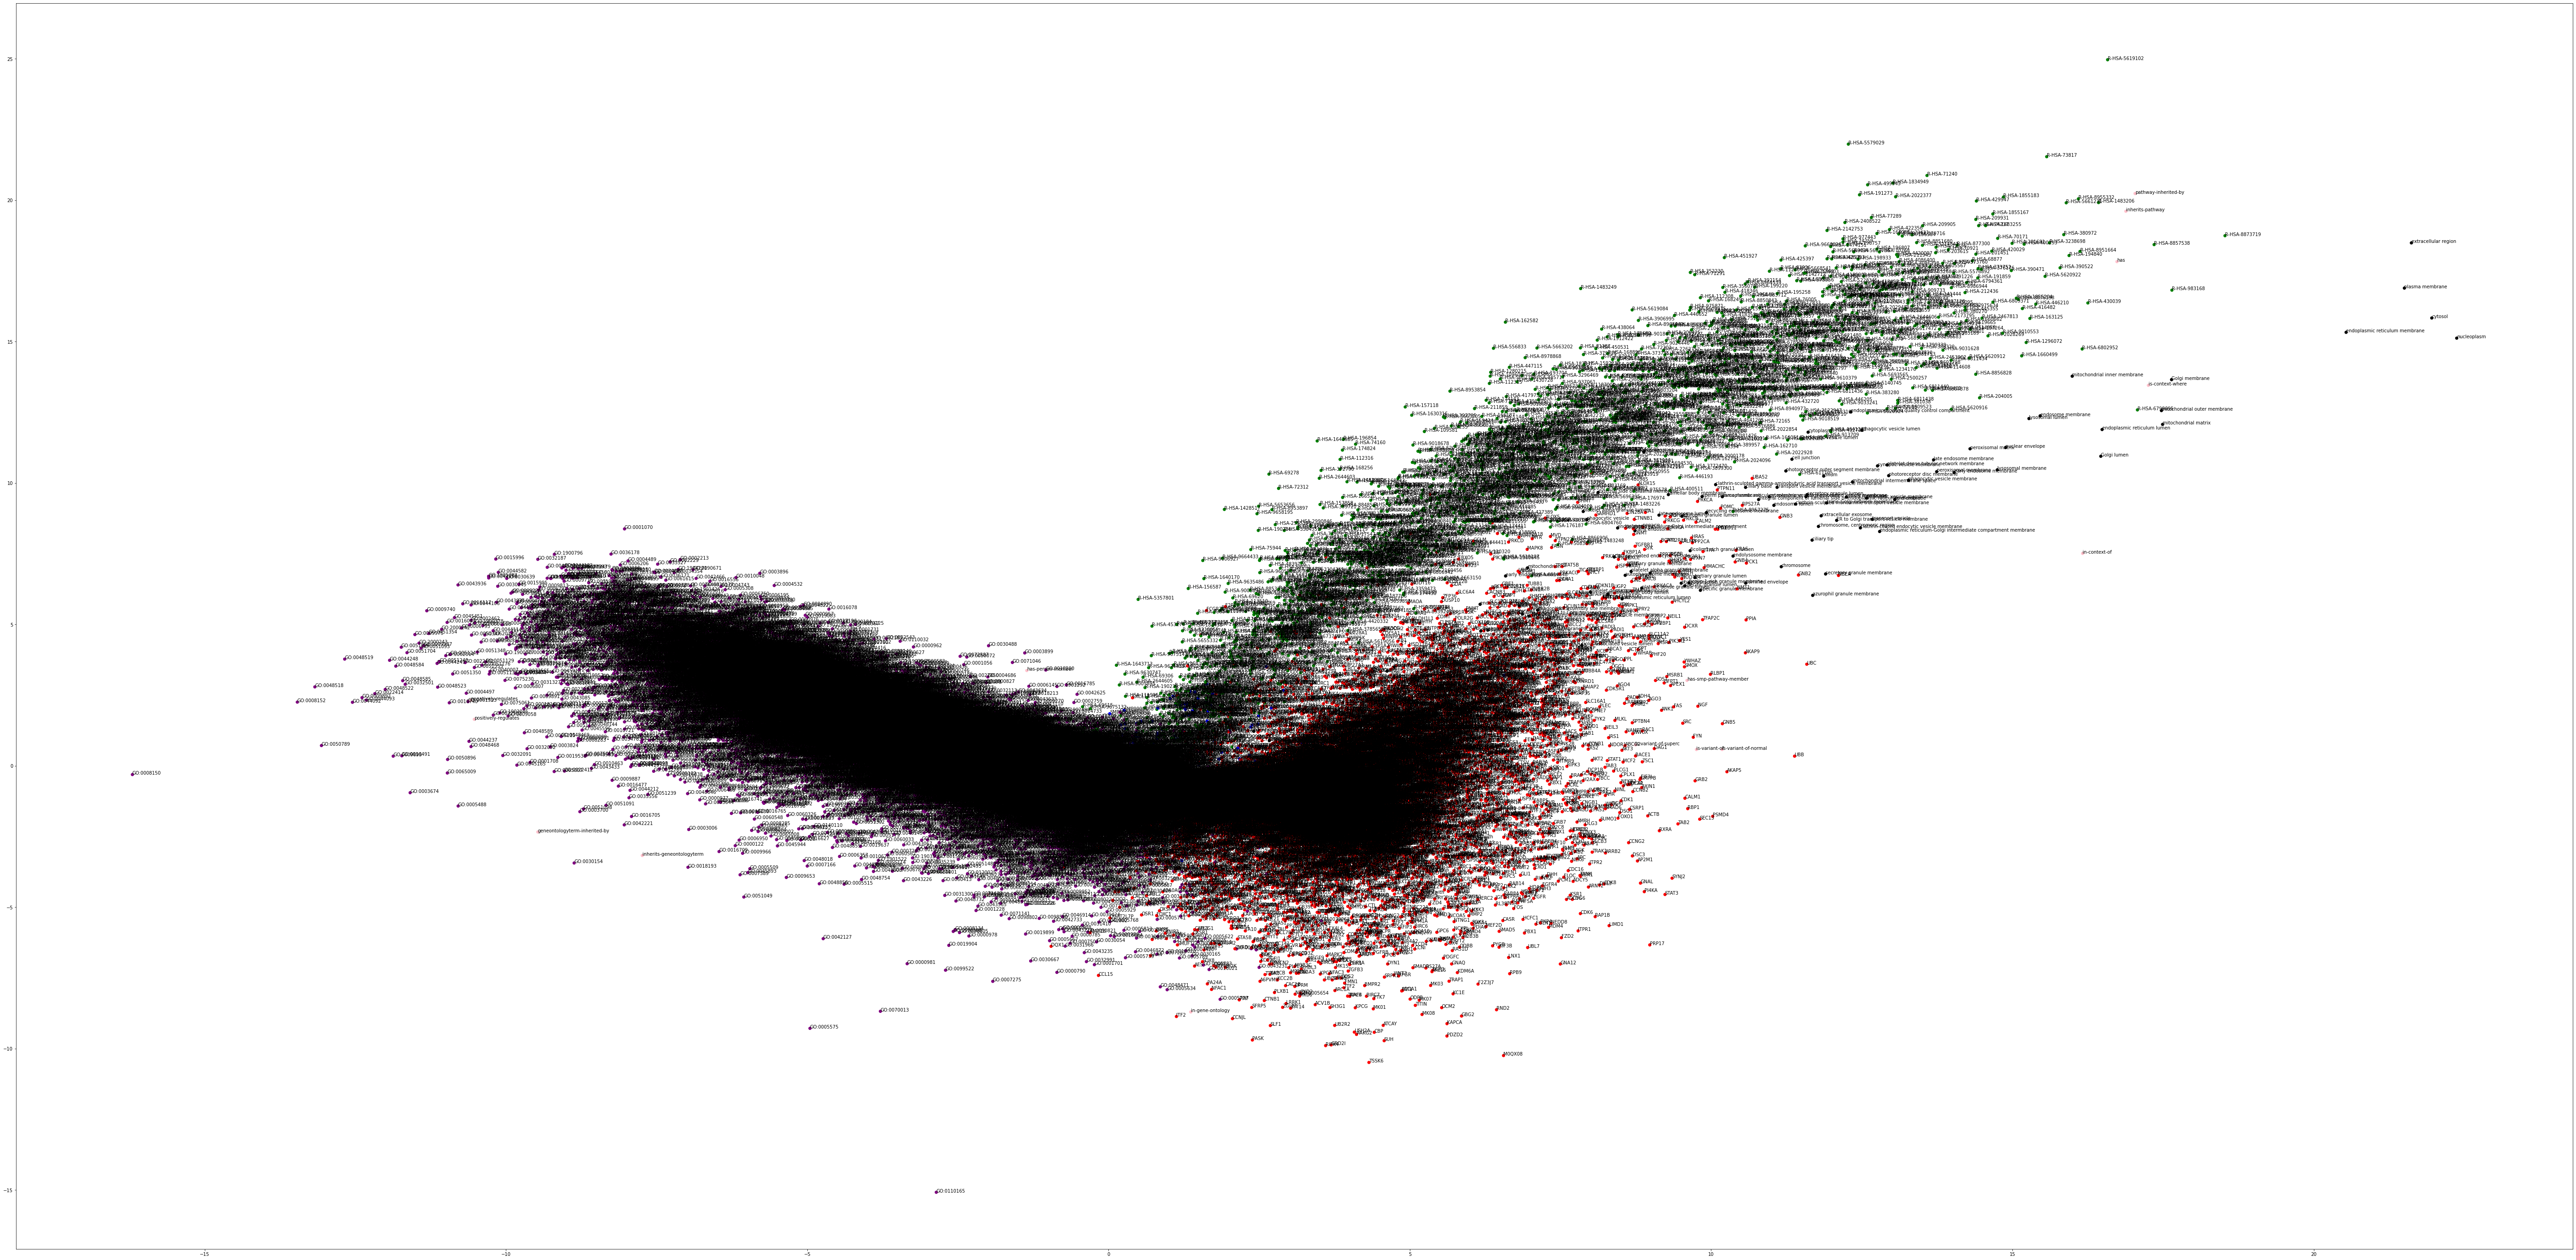

In [36]:
import matplotlib
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1],c=labels, cmap=matplotlib.colors.ListedColormap(colors))
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [37]:
model.most_similar("cytosol")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('endosome membrane', 0.7915505170822144),
 ('mitochondrial outer membrane', 0.7878899574279785),
 ('chromosome, centromeric region', 0.7842954993247986),
 ('late endosome lumen', 0.7795589566230774),
 ('Golgi-associated vesicle membrane', 0.7761436700820923),
 ('chromosome', 0.7732088565826416),
 ('cytoplasmic vesicle membrane', 0.7646511197090149),
 ('ciliary base', 0.7595604062080383),
 ('cornified envelope', 0.7588694095611572),
 ('extracellular exosome', 0.757492184638977)]

In [38]:
model.most_similar(positive=['superc'], negative=['normal'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('7:7493097_C/G', 0.4698264002799988),
 ('is-variant-of-superc', 0.46924203634262085),
 ('superc26', 0.40119755268096924),
 ('superc16', 0.396788626909256),
 ('superc21', 0.38795772194862366),
 ('superc9', 0.35847344994544983),
 ('superc-has-variant', 0.35545945167541504),
 ('superc6', 0.35461679100990295),
 ('superc23', 0.35397252440452576),
 ('superc11', 0.3510952591896057)]

In [39]:
model.most_similar("superc")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('superc26', 0.6980406045913696),
 ('superc23', 0.6934430003166199),
 ('superc21', 0.6928985118865967),
 ('superc16', 0.6874750256538391),
 ('superc17', 0.676184356212616),
 ('superc2', 0.6755746603012085),
 ('superc24', 0.674269437789917),
 ('superc0', 0.6680525541305542),
 ('superc25', 0.6666951179504395),
 ('superc15', 0.6662693023681641)]

In [40]:
#+b cell differentiation, -t cell differentiation,+ t cell proliferation
model.most_similar(positive=['GO:0030183','GO:0042098'], negative=['GO:0030217'])
#first one should be GO:0042100, b cell proliferation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0042100', 0.6712555289268494),
 ('GO:0050798', 0.6478325128555298),
 ('GO:0042104', 0.6129632592201233),
 ('GO:0042113', 0.6103603839874268),
 ('GO:0046651', 0.604892373085022),
 ('GO:0030101', 0.5991619825363159),
 ('GO:0042102', 0.5820620059967041),
 ('GO:0045579', 0.5800691843032837),
 ('GO:0001777', 0.5799813270568848),
 ('GO:0030889', 0.579596757888794)]

In [41]:
#+nucleus, +mitochondrial genome maintenence,-mitochondria
model.most_similar(positive=['GO:0005634','GO:0005739'], negative=['GO:0000002'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0005654', 0.5918369889259338),
 ('GO:0005737', 0.5431901812553406),
 ('GO:0008270', 0.5296216011047363),
 ('GO:0005730', 0.5112391710281372),
 ('GO:0005829', 0.504212498664856),
 ('GO:0016363', 0.4925931692123413),
 ('GO:0016235', 0.4882717430591583),
 ('GO:0005794', 0.47375601530075073),
 ('GO:0001650', 0.4730752408504486),
 ('GO:0046872', 0.4623890519142151)]

In [42]:
#+nucleus, +mitochondrial genome maintenence,-mitochondria
model.most_similar(positive=['GO:0005634','GO:0000002'], negative=['GO:0005739'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0010569', 0.5423327684402466),
 ('GO:0001673', 0.5239025354385376),
 ('GO:0033955', 0.5209658145904541),
 ('GO:0000978', 0.5193521976470947),
 ('GO:2000779', 0.5152691602706909),
 ('GO:0006289', 0.5107001662254333),
 ('GO:0000979', 0.504734218120575),
 ('GO:0003697', 0.496664822101593),
 ('GO:0032204', 0.4927930235862732),
 ('GO:0000790', 0.48145341873168945)]

In [43]:
#+nuclear transcription factor complex, +mitochondrial genome maintenence,-mitochondrian transcription
model.most_similar(positive=['GO:0044798','GO:0000002'], negative=['GO:0006390'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0033955', 0.5223358273506165),
 ('GO:0090576', 0.48176154494285583),
 ('GO:0090577', 0.4671383798122406),
 ('GO:0090575', 0.4545554518699646),
 ('GO:0090578', 0.44999295473098755),
 ('GO:1904834', 0.4387075901031494),
 ('GO:0008422', 0.4336811900138855),
 ('GO:0003288', 0.42898061871528625),
 ('GO:0002681', 0.42634910345077515),
 ('GO:0021781', 0.41439157724380493)]

In [44]:
genemembers = {}
for sentence in phrases:
    if sentence[1]=='has-gene-ontology-member':
        if sentence[0] not in genemembers:
            genemembers[sentence[0]] = set()
        genemembers[sentence[0]].add(sentence[2])


In [45]:
gomembers = {}
for sentence in phrases:
    if sentence[1]=='geneontologyterm-inherited-by':
        if sentence[0] not in gomembers:
            gomembers[sentence[0]] = set()
        gomembers[sentence[0]].add(sentence[2])


In [46]:
import pandas as pd
infodf = pd.read_csv("reasoning-bio-as-xp/csv/agingGOterms.csv")

In [47]:
aging_goterms= list(infodf["GOID"])

In [48]:
aging_goterms

['GO:0001300',
 'GO:0001301',
 'GO:0001302',
 'GO:0001303',
 'GO:0001304',
 'GO:0001305',
 'GO:0001307',
 'GO:0001308',
 'GO:0001310',
 'GO:0001311',
 'GO:0001312',
 'GO:0001313',
 'GO:0001314',
 'GO:0001316',
 'GO:0001317',
 'GO:0001318',
 'GO:0001319',
 'GO:0001320',
 'GO:0001321',
 'GO:0001322',
 'GO:0001323',
 'GO:0001324',
 'GO:0006323',
 'GO:0007568',
 'GO:0007569',
 'GO:0007580',
 'GO:0010259',
 'GO:0010978',
 'GO:0019072',
 'GO:0019073',
 'GO:0019074',
 'GO:0034652',
 'GO:0035177',
 'GO:0036385',
 'GO:0036386',
 'GO:0039631',
 'GO:0039632',
 'GO:0044815',
 'GO:0060756',
 'GO:0060757',
 'GO:0060758',
 'GO:0061434',
 'GO:0090139',
 'GO:0090342',
 'GO:0090343',
 'GO:0090344',
 'GO:0098006',
 'GO:0098035',
 'GO:0098036',
 'GO:0098037',
 'GO:1900007',
 'GO:1900008',
 'GO:1900009',
 'GO:1900062',
 'GO:1900160',
 'GO:1903368',
 'GO:1903369',
 'GO:1903370',
 'GO:1905137',
 'GO:1905138']

In [49]:
#each gene onotlogy term as measured by the genes

def compute_simularity_ratios(genemembers):
    num_first =0
    top_ten = 0
    total =0
    num_first_aging=0
    top_ten_aging=0
    total_aging=0

    for ontology_term, gene_children in genemembers.items() :
        children = list(gene_children)
        if all(gene in model.wv.vocab for gene in children):
            simlist = model.most_similar(positive=children)
            if len (simlist) >0:
                total +=1
                if ontology_term in aging_goterms:
                    total_aging +=1
                if simlist[0][0]==ontology_term:
                    num_first += 1
                    if ontology_term in aging_goterms:
                        num_first_aging +=1
                is_in_top_ten = False
                for tup in simlist:
                    if tup[0]==ontology_term:
                        is_in_top_ten = True 
                if is_in_top_ten:
                    if ontology_term in aging_goterms:
                        top_ten_aging +=1
                    top_ten += 1

                    
    ratio_in_top_ten= top_ten/total if total !=0 else 0
    ratio_first= num_first/total if total !=0 else 0
    ratio_in_top_ten_aging= top_ten_aging/total_aging if total_aging !=0 else 0
    ratio_first_aging= num_first_aging/total_aging if total_aging !=0 else 0
    return (ratio_first,ratio_in_top_ten,ratio_first_aging,ratio_in_top_ten_aging)

In [50]:
ratio_first, ratio_in_top_ten ,ratio_first_aging, ratio_in_top_ten_aging = compute_simularity_ratios(genemembers)
print ("Ratio of gene ontology terms that are closest to sum of gene children is {0}".format(ratio_first))
print ("Ratio of gene ontology terms that are top ten closest to sum of gene children is {0}".format(ratio_in_top_ten))
print ("Ratio of aging gene ontology terms that are closest to sum of gene children is {0}".format(ratio_first_aging))
print ("Ratio of aging gene ontology terms that are top ten closest to sum of gene children is {0}".format(ratio_in_top_ten_aging))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


Ratio of gene ontology terms that are closest to sum of gene children is 0.08093652786115811
Ratio of gene ontology terms that are top ten closest to sum of gene children is 0.2782841237788572
Ratio of aging gene ontology terms that are closest to sum of gene children is 0.1
Ratio of aging gene ontology terms that are top ten closest to sum of gene children is 0.3


In [51]:
#each gene onotlogy term as measured by child ontology terms
ratio_first1, ratio_in_top_ten1 ,ratio_first_aging1, ratio_in_top_ten_aging1 = compute_simularity_ratios(gomembers)
print ("Ratio of gene ontology terms that are closest to sum of gene ontology term children is {0}".format(ratio_first1))
print ("Ratio of gene ontology terms that are top ten closest to sum of gene ontology term children is {0}".format(ratio_in_top_ten1))
print ("Ratio of aging gene ontology terms that are closest to sum of gene ontology term children is {0}".format(ratio_first_aging1))
print ("Ratio of aging gene ontology terms that are top ten closest to sum of gene ontology term children is {0}".format(ratio_in_top_ten_aging1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


Ratio of gene ontology terms that are closest to sum of gene ontology term children is 0.6279518353986439
Ratio of gene ontology terms that are top ten closest to sum of gene ontology term children is 0.9498480243161094
Ratio of aging gene ontology terms that are closest to sum of gene ontology term children is 0.6538461538461539
Ratio of aging gene ontology terms that are top ten closest to sum of gene ontology term children is 0.9615384615384616


In [52]:
len (model.wv.vocab)

108070

In [53]:
model.most_similar(positive=supercpersonlist)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('19:20115976_C/T', 0.818567156791687),
 ('8:125551364_A/G', 0.7522746324539185),
 ('12:131624806_C/T', 0.7392654418945312),
 ('9:33259777_G/T', 0.7328484058380127),
 ('normal474', 0.7095082998275757),
 ('normal340', 0.7081515192985535),
 ('11:73562123_A/G', 0.7043241262435913),
 ('normal68', 0.703654408454895),
 ('2:232319578_C/A', 0.7021849155426025),
 ('normal252', 0.7001147866249084)]

In [54]:
model.most_similar("inhibits")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('is-inhibited-by', 0.9559117555618286),
 ('ptmod', 0.910630464553833),
 ('activates', 0.8791033625602722),
 ('is-ptmoded-by', 0.875476062297821),
 ('is-activated-by', 0.8509235382080078),
 ('reacts-with', 0.8355182409286499),
 ('binds-with', 0.7968524694442749),
 ('GRD2I', 0.6425315141677856),
 ('PDPK1', 0.6202993392944336),
 ('STAT3', 0.6151564717292786)]

In [55]:
#+b cell differentiation, -t cell differentiation, + t cell proliferation
model.most_similar(positive=['GO:0030183','GO:0042098'], negative=['GO:0030217'])
#first one should be GO:0042100, b cell proliferation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('GO:0042100', 0.6712555289268494),
 ('GO:0050798', 0.6478325128555298),
 ('GO:0042104', 0.6129632592201233),
 ('GO:0042113', 0.6103603839874268),
 ('GO:0046651', 0.604892373085022),
 ('GO:0030101', 0.5991619825363159),
 ('GO:0042102', 0.5820620059967041),
 ('GO:0045579', 0.5800691843032837),
 ('GO:0001777', 0.5799813270568848),
 ('GO:0030889', 0.579596757888794)]

In [84]:
# Testing
from scipy.spatial import distance

a = model['GO:0030183']
b = model['GO:0030217']
c = model['GO:0042100']
d = model['GO:0042098']

e = model["is-inhibited-by"]
f = model["inhibits"]

e = model["GO:0046900"]
f = model["GO:0046901"]

print(distance.euclidean(e, f))
print(2 ** -distance.euclidean(e, f))

3.258277654647827
0.10451068439382587


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Met

In [56]:
# Output all the GOs in the model (in form of GO-pairs) to a file named "dw_pairs.txt"
go_vocabs = []
go_pairs = []
f = open("reasoning-bio-as-xp/dw_pairs.txt", "w")
for v in model.wv.vocab:
    if v.startswith("GO:"):
        go_vocabs.append(v)

i = 0
while (i + 1) < len(go_vocabs):
    f.write(go_vocabs[i] + "," + go_vocabs[i+1] + "\n")
    i = i + 2

f.close()

In [80]:
# Calculate the similarity values for the GO-pairs in "dw_pairs.txt"
from scipy.spatial import distance

f1 = open("reasoning-bio-as-xp/dw_pairs.txt", "r")
lines = f1.readlines()

f2 = open("reasoning-bio-as-xp/dw_results_all.txt", "w")

for line in lines:
    # print("Reading: {}".format(line))
    gos = line.split(",")
    go1 = gos[0].strip()
    go2 = gos[1].strip()
    go_similarity = 2 ** (-distance.euclidean(model[go1], model[go2]))
    print("Similarity between {} and {} is {}\n".format(go1, go2, go_similarity))
    f2.write("{},{},{}\n".format(go1, go2, go_similarity))

f1.close()
f2.close()

Similarity between GO:0050573 and GO:0016616 is 1.261727291964365e-07

Similarity between GO:0019362 and GO:0046496 is 0.00435033034243257

Similarity between GO:0019677 and GO:0006742 is 0.023368554687344233

Similarity between GO:0006739 and GO:0008152 is 2.360603144506788e-10

Similarity between GO:0008150 and GO:0005575 is 1.230705094542351e-12

Similarity between GO:0005623 and GO:0014707 is 3.450558041713376e-10

Similarity between GO:0003700 and GO:0051091 is 1.1343982573679574e-07

Similarity between GO:0051092 and GO:0008284 is 4.9834964823894175e-08

Similarity between GO:0070665 and GO:0070661 is 0.002175664886323745

Similarity between GO:0015057 and GO:0061930 is 0.00011085254316296106

Similarity between GO:0061931 and GO:0043131 is 0.0008829953205654297

Similarity between GO:0061932 and GO:0090601 is 0.0008176632619624773

Similarity between GO:0090602 and GO:0034395 is 0.00016202387032401546

Similarity between GO:0010723 and GO:0006413 is 1.367798014235335e-07

Simila

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  



Similarity between GO:0002889 and GO:0002712 is 0.00946271693099482

Similarity between GO:0002622 and GO:0002577 is 0.00010802102888381675

Similarity between GO:0002580 and GO:0080011 is 0.0004829493355565675

Similarity between GO:0031559 and GO:0016866 is 8.917730774018876e-05

Similarity between GO:0004106 and GO:0016853 is 8.451016872886675e-07

Similarity between GO:0010912 and GO:1903507 is 5.460353366933922e-09

Similarity between GO:1902679 and GO:2001141 is 4.477559242910937e-06

Similarity between GO:1903932 and GO:1903933 is 0.0019411123766220248

Similarity between GO:1903934 and GO:0003896 is 0.0002589843652118865

Similarity between GO:1905216 and GO:1905214 is 3.95435088671071e-07

Similarity between GO:1905215 and GO:1904572 is 3.718000165832276e-05

Similarity between GO:1902415 and GO:1905610 is 0.0011041104243632938

Similarity between GO:1905611 and GO:0098808 is 0.00517364728007825

Similarity between GO:1905612 and GO:0004366 is 3.562728179229676e-05

Similarit


Similarity between GO:0150174 and GO:0019616 is 1.4642189159839124e-06

Similarity between GO:0019614 and GO:0019336 is 0.0001272379241494812

Similarity between GO:0030170 and GO:0032343 is 2.8246390314319063e-08

Similarity between GO:0032341 and GO:0032346 is 0.0022390619744521376

Similarity between GO:0006081 and GO:0046487 is 6.097346033122325e-06

Similarity between GO:2001067 and GO:0030247 is 1.4866624839979971e-05

Similarity between GO:0070492 and GO:0018698 is 3.23653244236369e-07

Similarity between GO:0050679 and GO:0050673 is 6.519730827586837e-05

Similarity between GO:0070346 and GO:0070341 is 0.0036911652579943405

Similarity between GO:0070343 and GO:0061587 is 7.44698467858054e-05

Similarity between GO:0036095 and GO:0006359 is 4.0631396366537616e-07

Similarity between GO:0016480 and GO:0021945 is 1.2719874164719916e-05

Similarity between GO:0050849 and GO:0071104 is 5.922226402456401e-06

Similarity between GO:0071355 and GO:0071345 is 5.027220275768675e-05

Si

Similarity between GO:0018035 and GO:0018195 is 0.00023858392740148146

Similarity between GO:0018120 and GO:0048510 is 9.317854217802681e-05

Similarity between GO:1901862 and GO:0090344 is 1.16362514334885e-05

Similarity between GO:2000773 and GO:0045644 is 1.1612891267052213e-05

Similarity between GO:0030222 and GO:0070742 is 8.405431661124784e-06

Similarity between GO:0032399 and GO:0018875 is 0.00015439829430073768

Similarity between GO:0010128 and GO:0018874 is 0.006546481859901916

Similarity between GO:0042198 and GO:0018945 is 0.0005372347592346214

Similarity between GO:0071055 and GO:0030096 is 0.049797426086840735

Similarity between GO:0008430 and GO:0070679 is 7.712528894011914e-05

Similarity between GO:0043168 and GO:0043167 is 8.833135766139675e-06

Similarity between GO:0097216 and GO:0032561 is 0.0004964789581629512

Similarity between GO:0120121 and GO:0150107 is 1.1826958712040938e-05

Similarity between GO:0150106 and GO:0032880 is 6.964430149740536e-05

Simil


Similarity between GO:0042795 and GO:0009301 is 0.00010414386251726771

Similarity between GO:0048096 and GO:0045815 is 3.986214410714543e-05

Similarity between GO:0031936 and GO:0042167 is 1.0993731097877264e-07

Similarity between GO:0046163 and GO:0046162 is 0.11645325392823463

Similarity between GO:0006786 and GO:0070971 is 5.487520001706584e-06

Similarity between GO:0001003 and GO:0001031 is 0.14211630086735652

Similarity between GO:0000992 and GO:0001039 is 0.010149490232703565

Similarity between GO:0001037 and GO:0001016 is 0.009458098591078025

Similarity between GO:0000979 and GO:0030954 is 2.2906670157703776e-05

Similarity between GO:0086077 and GO:0086075 is 0.004263580647551819

Similarity between GO:1903763 and GO:0086020 is 0.016613024262767492

Similarity between GO:0005243 and GO:0006487 is 7.556796092503001e-07

Similarity between GO:0042281 and GO:0033831 is 0.05393078721789431

Similarity between GO:0047228 and GO:0002487 is 0.014971688198682123

Similarity be


Similarity between GO:0050258 and GO:0008660 is 0.08449883628728208

Similarity between GO:0019239 and GO:0004153 is 4.927298699291186e-06

Similarity between GO:0051343 and GO:1900354 is 8.18544299593004e-06

Similarity between GO:0009915 and GO:0090449 is 0.02095751052354681

Similarity between GO:0150195 and GO:0097717 is 0.10368660117914665

Similarity between GO:0006825 and GO:0000041 is 0.0010921938578294212

Similarity between GO:0015694 and GO:2000899 is 4.812609691806681e-06

Similarity between GO:2000952 and GO:2000949 is 0.030324223096055786

Similarity between GO:2000948 and GO:2000951 is 0.10740916194731225

Similarity between GO:2000990 and GO:0000423 is 5.110496733031871e-05

Similarity between GO:1901525 and GO:1904924 is 0.0029767446061590686

Similarity between GO:0016242 and GO:0035695 is 5.2331425042427e-05

Similarity between GO:0005986 and GO:0005985 is 0.02198330033779468

Similarity between GO:0005984 and GO:0005988 is 0.0016313672579722272

Similarity between 


Similarity between GO:0016818 and GO:0047586 is 0.00011580908268271545

Similarity between GO:0003998 and GO:0033987 is 0.0007885241108093962

Similarity between GO:0033994 and GO:1904043 is 0.0002923712191317241

Similarity between GO:0060084 and GO:0007274 is 0.0007559587882222526

Similarity between GO:0003009 and GO:0102537 is 4.831639409862231e-05

Similarity between GO:2001145 and GO:2001144 is 0.006231405379353291

Similarity between GO:2000613 and GO:0070460 is 0.010396377746387022

Similarity between GO:2000614 and GO:2000612 is 0.010833193756950578

Similarity between GO:0035776 and GO:0072014 is 0.011128828903262371

Similarity between GO:0035295 and GO:0061205 is 2.6642017155270426e-05

Similarity between GO:0072013 and GO:0033220 is 0.00020304954505694306

Similarity between GO:0015625 and GO:0015453 is 0.004289787271731926

Similarity between GO:0009678 and GO:0005452 is 0.0001740053514105735

Similarity between GO:0052866 and GO:0052744 is 0.015594889908707875

Similari


Similarity between GO:1902815 and GO:0015739 is 0.013076119090423912

Similarity between GO:0031999 and GO:1990588 is 5.621836931170762e-06

Similarity between GO:1990586 and GO:0031905 is 4.536974727361798e-05

Similarity between GO:0042900 and GO:0015146 is 0.08373678944598341

Similarity between GO:0015148 and GO:0015614 is 0.05508716874812288

Similarity between GO:0015145 and GO:0140406 is 2.6547138045306162e-05

Similarity between GO:0032973 and GO:0140115 is 0.00010821092096722998

Similarity between GO:0140352 and GO:0055053 is 1.2669172515087192e-05

Similarity between GO:0009679 and GO:0055054 is 0.002998042482242839

Similarity between GO:0005353 and GO:0044680 is 8.121278900592366e-05

Similarity between GO:0034708 and GO:0030369 is 2.520247083962222e-06

Similarity between GO:0019495 and GO:0006562 is 0.0014414705602439858

Similarity between GO:0097122 and GO:0003829 is 0.0020007222760238027

Similarity between GO:0120107 and GO:0047946 is 0.00041272711788595604

Similar


Similarity between GO:0039641 and GO:0098024 is 0.01327673936781446

Similarity between GO:0019028 and GO:0019030 is 0.0008573415184693711

Similarity between GO:0039617 and GO:0051640 is 3.2266416973675675e-06

Similarity between GO:0043204 and GO:0006602 is 8.034366028808119e-08

Similarity between GO:0043436 and GO:0018868 is 7.39562653343668e-05

Similarity between GO:1900605 and GO:1900603 is 6.588548045725552e-05

Similarity between GO:0090664 and GO:0034314 is 5.5406419621356925e-06

Similarity between GO:0035902 and GO:0051606 is 4.445630715388419e-07

Similarity between GO:1902650 and GO:1902649 is 0.011988607153144442

Similarity between GO:0090308 and GO:0045125 is 7.651298373949704e-05

Similarity between GO:1903781 and GO:1903951 is 0.004393717131980232

Similarity between GO:1905027 and GO:1905028 is 0.003518035294539566

Similarity between GO:0007119 and GO:0007117 is 0.012098583206616977

Similarity between GO:0007118 and GO:0009128 is 0.00034061681522947097

Similarit


Similarity between GO:0072207 and GO:1905408 is 1.4856545362367006e-05

Similarity between GO:0006998 and GO:1900454 is 2.1804078864791717e-07

Similarity between GO:0098974 and GO:0010313 is 1.9055199561424402e-05

Similarity between GO:0072334 and GO:2000701 is 1.253285009240804e-06

Similarity between GO:2000735 and GO:0098521 is 1.5214412075100967e-05

Similarity between GO:0098525 and GO:0043684 is 0.0011563435950314878

Similarity between GO:0002884 and GO:0001804 is 0.016594974475363365

Similarity between GO:0001802 and GO:0002444 is 0.0016614798734081147

Similarity between GO:0002446 and GO:0061098 is 3.701038823307733e-05

Similarity between GO:0061097 and GO:0050392 is 3.280982487922278e-05

Similarity between GO:0071179 and GO:0042391 is 1.4259744436569193e-07

Similarity between GO:0045837 and GO:0060913 is 2.3622103724297182e-05

Similarity between GO:0021522 and GO:0021515 is 0.0012671248392564245

Similarity between GO:0048311 and GO:0051646 is 0.0012423506402667078




Similarity between GO:0072097 and GO:0030509 is 1.3725112551171135e-05

Similarity between GO:0030514 and GO:0003154 is 1.4437584379069924e-05

Similarity between GO:0048599 and GO:0071510 is 6.887442624212509e-06

Similarity between GO:0000185 and GO:0042655 is 0.0017418717561581546

Similarity between GO:0004706 and GO:0102851 is 6.899043607820045e-05

Similarity between GO:0007605 and GO:2000893 is 1.3962843211710651e-08

Similarity between GO:0009847 and GO:0110151 is 1.1504014640931608e-06

Similarity between GO:0070169 and GO:0031214 is 5.153969174523277e-05

Similarity between GO:1904149 and GO:1904151 is 0.0018523048293589378

Similarity between GO:0090634 and GO:1904150 is 0.019086227509165696

Similarity between GO:0001909 and GO:0001911 is 0.0032114288935161466

Similarity between GO:0001915 and GO:0000377 is 3.2945507554445597e-06

Similarity between GO:0000375 and GO:0005665 is 6.204592322894042e-05

Similarity between GO:0018876 and GO:0010683 is 0.0003172931970675611

S

Similarity between GO:0072396 and GO:1900522 is 2.5698824835865155e-06

Similarity between GO:0044591 and GO:0045460 is 3.7625261947454994e-06

Similarity between GO:0045461 and GO:1900760 is 0.002524393402649864

Similarity between GO:0010914 and GO:0015920 is 1.4221824759275427e-05

Similarity between GO:0015921 and GO:0007211 is 1.4060966437328908e-05

Similarity between GO:2000127 and GO:2000130 is 0.05385770034424234

Similarity between GO:0071935 and GO:2000140 is 0.00896158081250575

Similarity between GO:2000126 and GO:0099575 is 3.8053481716911074e-05

Similarity between GO:0043161 and GO:0030433 is 0.0001179331028039161

Similarity between GO:0097058 and GO:0008794 is 0.00022128999143414932

Similarity between GO:0034591 and GO:0102545 is 0.004177236567161745

Similarity between GO:0033138 and GO:0033141 is 0.0004487612780513073

Similarity between GO:0098593 and GO:0031411 is 0.29315978105851315

Similarity between GO:1901317 and GO:0009792 is 4.975227646274421e-06

Similari


Similarity between GO:0015826 and GO:1905009 is 0.000709017015915688

Similarity between GO:0033603 and GO:1904006 is 6.603595568495951e-06

Similarity between GO:0010519 and GO:0106162 is 4.966529540601502e-05

Similarity between GO:0097260 and GO:0052840 is 0.0008661979662305332

Similarity between GO:1902557 and GO:0000295 is 0.010513578814701009

Similarity between GO:0008835 and GO:0050228 is 0.39667141435077197

Similarity between GO:1904283 and GO:0002590 is 0.004434689234777099

Similarity between GO:0005539 and GO:0018050 is 4.654617720858317e-06

Similarity between GO:1901875 and GO:0046608 is 6.984107013154872e-06

Similarity between GO:0007391 and GO:0016331 is 7.352005987063753e-05

Similarity between GO:0045123 and GO:0010456 is 2.2157645904476556e-05

Similarity between GO:1902833 and GO:0021921 is 0.016568147385463805

Similarity between GO:0070306 and GO:0030855 is 2.8965115460983037e-05

Similarity between GO:0060690 and GO:0060704 is 0.15071603816548768

Similarity 


Similarity between GO:0090370 and GO:0140442 is 0.00010343541126090501

Similarity between GO:0015049 and GO:0045871 is 0.003547173518234438

Similarity between GO:0010678 and GO:0034155 is 0.0007890084945946621

Similarity between GO:0034156 and GO:0062207 is 5.997889275275568e-05

Similarity between GO:0039021 and GO:0032673 is 0.00021103447376504835

Similarity between GO:0034142 and GO:0060604 is 7.823674453228387e-06

Similarity between GO:0060605 and GO:1903133 is 0.0045587398557109466

Similarity between GO:0060662 and GO:0006748 is 0.0003121593693352659

Similarity between GO:0090642 and GO:0020025 is 0.0008209751416459694

Similarity between GO:0005883 and GO:0061003 is 1.0586069455870451e-05

Similarity between GO:0022819 and GO:0015079 is 4.313082240068691e-05

Similarity between GO:0061768 and GO:0033484 is 0.0017671175266146828

Similarity between GO:1902396 and GO:0008716 is 0.0033605480663543475

Similarity between GO:0071983 and GO:0071981 is 0.021559421544975265

Simi

Similarity between GO:0015013 and GO:0030201 is 0.008272910025681805

Similarity between GO:0006029 and GO:0102687 is 2.0030395992155804e-05

Similarity between GO:0102949 and GO:0102825 is 0.4334061506294038

Similarity between GO:0102423 and GO:2001129 is 2.8218019138173407e-05

Similarity between GO:1900319 and GO:0072182 is 7.23133369156217e-05

Similarity between GO:2000768 and GO:0031116 is 9.067809806400209e-06

Similarity between GO:0046785 and GO:0031115 is 0.0025391595076609203

Similarity between GO:1900016 and GO:1904133 is 6.128233676045163e-06

Similarity between GO:1904135 and GO:0060026 is 0.00017288838879051576

Similarity between GO:0021681 and GO:0030176 is 2.357306321084551e-07

Similarity between GO:0090740 and GO:0009671 is 0.002873000858688847

Similarity between GO:0097079 and GO:0030332 is 5.866112857685737e-06

Similarity between GO:0042069 and GO:0045914 is 0.0023781834741548715

Similarity between GO:0006584 and GO:0042423 is 6.603053980443472e-05

Similarit


Similarity between GO:0071827 and GO:0034377 is 0.0015547912235651291

Similarity between GO:0005773 and GO:0048934 is 2.654124365860835e-06

Similarity between GO:0042490 and GO:0003053 is 9.13799630560324e-07

Similarity between GO:0003055 and GO:0047976 is 0.001110703125428207

Similarity between GO:0008156 and GO:2000104 is 0.00037759156337377817

Similarity between GO:0035076 and GO:0030518 is 0.0012233073800646608

Similarity between GO:0033145 and GO:0043401 is 9.05353055250821e-05

Similarity between GO:0018665 and GO:0043082 is 0.009510134054014432

Similarity between GO:0042730 and GO:0051919 is 0.00021429967833786072

Similarity between GO:0051917 and GO:0035232 is 0.00032123887323247006

Similarity between GO:0010172 and GO:0006573 is 8.383778511294275e-05

Similarity between GO:0009081 and GO:0060168 is 1.625575964057904e-05

Similarity between GO:0035588 and GO:0010343 is 0.000573319696464863

Similarity between GO:0097468 and GO:0007100 is 1.5884661682223267e-05

Simila


Similarity between GO:0030496 and GO:0060736 is 1.1593119116853286e-07

Similarity between GO:0060737 and GO:0048639 is 1.9012886570555988e-06

Similarity between GO:0070838 and GO:0015691 is 0.0032523789950294297

Similarity between GO:0070574 and GO:0071577 is 0.00016315744025152798

Similarity between GO:0006882 and GO:2000872 is 2.9860612323838516e-07

Similarity between GO:1905939 and GO:2000018 is 0.011041034367120143

Similarity between GO:1904444 and GO:0030856 is 3.176900835569546e-05

Similarity between GO:0097361 and GO:0046670 is 1.5052651854279561e-05

Similarity between GO:0046672 and GO:0046667 is 0.007460008561623903

Similarity between GO:0046673 and GO:0046669 is 0.007961673823762273

Similarity between GO:0046668 and GO:0051102 is 3.3503054011804877e-05

Similarity between GO:2000336 and GO:2000337 is 0.0024836552418854873

Similarity between GO:0033658 and GO:0033657 is 0.04854068595686404

Similarity between GO:0033656 and GO:0052188 is 0.0032954432984119127

Simi


Similarity between GO:1904947 and GO:0046849 is 1.0528898577766448e-05

Similarity between GO:0002558 and GO:0002448 is 0.07352515219710452

Similarity between GO:0035446 and GO:0047581 is 0.4849792621370159

Similarity between GO:0003833 and GO:0050785 is 2.57152220974353e-05

Similarity between GO:1904605 and GO:1904603 is 0.013442112293617942

Similarity between GO:1904604 and GO:0006202 is 0.00012315029551857807

Similarity between GO:0046038 and GO:0009259 is 3.229477446780985e-05

Similarity between GO:1901115 and GO:1901113 is 0.03817610141766855

Similarity between GO:0099637 and GO:0015591 is 2.1385731703247382e-05

Similarity between GO:0015577 and GO:0022875 is 0.21259134467260266

Similarity between GO:1902081 and GO:1903779 is 2.90539225141366e-06

Similarity between GO:0046964 and GO:0075249 is 1.8577826743066427e-05

Similarity between GO:0045881 and GO:0017018 is 6.126159921579688e-06

Similarity between GO:0030898 and GO:1904622 is 0.0024937497063336955

Similarity be


Similarity between GO:0086050 and GO:1905650 is 0.00015362273328986642

Similarity between GO:0031215 and GO:1905649 is 0.008819344707203858

Similarity between GO:0021833 and GO:0031589 is 4.8165558995211634e-05

Similarity between GO:0021612 and GO:0021604 is 0.0003055918200829378

Similarity between GO:0021609 and GO:0021600 is 0.4043319791536399

Similarity between GO:0021633 and GO:0098904 is 0.00016470138990043454

Similarity between GO:1901381 and GO:0072090 is 9.83616629946347e-06

Similarity between GO:0097168 and GO:0033002 is 5.213227258402367e-05

Similarity between GO:0038007 and GO:0050553 is 2.5938837794804317e-05

Similarity between GO:0102304 and GO:0102882 is 0.3942280855956676

Similarity between GO:0052678 and GO:0102903 is 0.4693411337053499

Similarity between GO:0090463 and GO:1903474 is 1.0526880889813424e-06

Similarity between GO:1903485 and GO:1903484 is 0.0005781561278250923

Similarity between GO:0007135 and GO:0007147 is 0.027458442261489285

Similarity b


Similarity between GO:0102659 and GO:0047656 is 0.08532029614682855

Similarity between GO:0090679 and GO:1905917 is 0.011424754241768673

Similarity between GO:1904760 and GO:0097078 is 0.0012023245949481837

Similarity between GO:0016914 and GO:0009355 is 0.0011219535714630377

Similarity between GO:1990303 and GO:0048000 is 0.035270395287720704

Similarity between GO:0042918 and GO:0042908 is 8.786441872417416e-05

Similarity between GO:0004013 and GO:1990731 is 0.00013498638736893394

Similarity between GO:0045707 and GO:0030115 is 0.0008307360926660585

Similarity between GO:0004620 and GO:0010236 is 1.0987061239968922e-06

Similarity between GO:0035538 and GO:0097206 is 0.0005886988183507923

Similarity between GO:0097205 and GO:0060135 is 1.9378458609820062e-05

Similarity between GO:0071131 and GO:0000148 is 0.0169178138832395

Similarity between GO:1900132 and GO:1900130 is 6.03107912410928e-05

Similarity between GO:1900131 and GO:2000755 is 7.053190550635154e-08

Similarity


Similarity between GO:0010654 and GO:0019232 is 0.003092705088005137

Similarity between GO:0004142 and GO:0005802 is 1.4599335201938721e-06

Similarity between GO:0061692 and GO:0098869 is 0.00016307732511131558

Similarity between GO:0051145 and GO:0051152 is 0.0011817345258221606

Similarity between GO:0060979 and GO:0031960 is 0.00012400402421168595

Similarity between GO:0048545 and GO:0046892 is 1.707972635388898e-05

Similarity between GO:1904313 and GO:0035484 is 0.0006552311705515585

Similarity between GO:0033295 and GO:0010838 is 1.3059224671904848e-05

Similarity between GO:0036158 and GO:0097554 is 0.0025265887189845986

Similarity between GO:0097555 and GO:0097560 is 0.4021758682058391

Similarity between GO:0034329 and GO:0010966 is 6.822842366265416e-07

Similarity between GO:0015400 and GO:0047007 is 0.003411948243547185

Similarity between GO:0033764 and GO:0043718 is 2.929371038529969e-06

Similarity between GO:0008677 and GO:0047838 is 0.3873395794438291

Similarit


Similarity between GO:0045293 and GO:0031019 is 0.005223157614878169

Similarity between GO:0036396 and GO:0070354 is 0.0003355138926112032

Similarity between GO:0046111 and GO:0030553 is 0.0001126733345873026

Similarity between GO:2000050 and GO:0070501 is 1.0442560901897554e-05

Similarity between GO:0070500 and GO:1900863 is 8.379894479800306e-05

Similarity between GO:1900799 and GO:1900862 is 0.00198082098154815

Similarity between GO:1905413 and GO:0102838 is 0.007299714425820698

Similarity between GO:0070704 and GO:1902466 is 7.850842095805868e-06

Similarity between GO:0061087 and GO:0005249 is 5.401440884459811e-06

Similarity between GO:0080173 and GO:0080166 is 0.004048519082576896

Similarity between GO:0001824 and GO:0086003 is 1.016335614961325e-06

Similarity between GO:0106135 and GO:0055118 is 0.004691659976763235

Similarity between GO:0098911 and GO:0030591 is 5.535553060650965e-05

Similarity between GO:0140294 and GO:0061648 is 0.00013038789346652476

Similarit

Similarity between GO:0016264 and GO:1903598 is 0.002063047628409056

Similarity between GO:1900221 and GO:1900222 is 0.0001437518809618573

Similarity between GO:0060278 and GO:1903186 is 0.00355464021197615

Similarity between GO:0060800 and GO:0072308 is 2.4361411912384728e-05

Similarity between GO:0072307 and GO:0050902 is 0.0008230611922648428

Similarity between GO:1902596 and GO:0018671 is 0.0002393889866569476

Similarity between GO:0034862 and GO:0050871 is 3.2812233996333764e-06

Similarity between GO:1904437 and GO:1904889 is 0.00011499269239003043

Similarity between GO:0051963 and GO:0035989 is 1.7000382172497645e-05

Similarity between GO:0003096 and GO:1903077 is 7.430512506715988e-07

Similarity between GO:0015880 and GO:0035349 is 0.011765001488064898

Similarity between GO:1990559 and GO:0051724 is 0.01164733531071279

Similarity between GO:0051185 and GO:0015230 is 0.003094537405323876

Similarity between GO:0008657 and GO:0009380 is 0.0003172537679395998

Similarit


Similarity between GO:2001121 and GO:0046256 is 6.730299870731788e-05

Similarity between GO:0046258 and GO:0018974 is 0.11407302605696651

Similarity between GO:0032117 and GO:0005818 is 0.07408464737402581

Similarity between GO:0099081 and GO:1904432 is 7.284800673618174e-05

Similarity between GO:1904433 and GO:0102567 is 2.418210035234606e-06

Similarity between GO:0019937 and GO:0018419 is 0.08699892473694561

Similarity between GO:0098639 and GO:0032484 is 0.0005992736923925038

Similarity between GO:0060826 and GO:0097268 is 0.00019936658132758321

Similarity between GO:0002865 and GO:0106014 is 0.00018360220456914704

Similarity between GO:0043379 and GO:0007602 is 2.0719972239271748e-07

Similarity between GO:0009583 and GO:0009649 is 8.477346726241112e-05

Similarity between GO:0080163 and GO:0021828 is 0.0003625850810089341

Similarity between GO:0071934 and GO:0021904 is 3.246558186155509e-05

Similarity between GO:0072647 and GO:0032480 is 4.9458958216235796e-05

Similar


Similarity between GO:0043008 and GO:1901846 is 3.7408757509966617e-06

Similarity between GO:1905199 and GO:0071880 is 2.0324386888145683e-05

Similarity between GO:0071878 and GO:0140199 is 0.008665825024283392

Similarity between GO:0033517 and GO:0033518 is 0.026000093569109758

Similarity between GO:0046838 and GO:0034412 is 0.00011572589832027774

Similarity between GO:0070880 and GO:0070879 is 0.11583266586875887

Similarity between GO:0099540 and GO:0099551 is 0.046867575106779975

Similarity between GO:0031981 and GO:0060992 is 5.13858589307019e-05

Similarity between GO:0070966 and GO:0070293 is 1.7519391715583692e-05

Similarity between GO:0097017 and GO:0097018 is 0.001327674440569161

Similarity between GO:0036067 and GO:0036069 is 0.25361330907240787

Similarity between GO:0030494 and GO:0030493 is 0.05925512636686172

Similarity between GO:0030495 and GO:1990525 is 0.0019380480778545977

Similarity between GO:0032093 and GO:0050446 is 0.0039041357714731106

Similarity b

Similarity between GO:1905699 and GO:0046116 is 0.00011231230797338592

Similarity between GO:0005042 and GO:0047641 is 0.00021375286148331632

Similarity between GO:0052749 and GO:0018699 is 0.0001970803433036725

Similarity between GO:0010041 and GO:0004370 is 0.0002177669320159132

Similarity between GO:0061610 and GO:0046327 is 0.005205602587967295

Similarity between GO:1905325 and GO:1905326 is 0.001209006534815087

Similarity between GO:0090687 and GO:0004582 is 0.0007604424962466199

Similarity between GO:0051377 and GO:0051267 is 0.18093678578214376

Similarity between GO:0090732 and GO:0090377 is 0.0006955554847455881

Similarity between GO:0031135 and GO:1903138 is 0.00013351607513770644

Similarity between GO:0047861 and GO:0019162 is 0.44656115897762644

Similarity between GO:0008793 and GO:0080130 is 0.2090102463351329

Similarity between GO:0070546 and GO:0019659 is 3.917496417723875e-05

Similarity between GO:0009114 and GO:0006150 is 0.09775749799296847

Similarity bet


Similarity between GO:0035036 and GO:0007339 is 0.0006337793993126658

Similarity between GO:2000360 and GO:0070148 is 5.248028500383174e-06

Similarity between GO:0006425 and GO:0035807 is 0.0001992243004128608

Similarity between GO:1903865 and GO:1904932 is 2.0398441753432866e-05

Similarity between GO:0070901 and GO:0071808 is 0.00021216620440247795

Similarity between GO:0018931 and GO:0016098 is 4.1913267819122805e-05

Similarity between GO:0070819 and GO:0034845 is 0.03951770772021267

Similarity between GO:0046956 and GO:0031335 is 2.895766823424837e-05

Similarity between GO:0061669 and GO:1902217 is 5.244477047203753e-05

Similarity between GO:0033028 and GO:0001781 is 0.0011556718953312857

Similarity between GO:2000106 and GO:0018963 is 1.2787859762572795e-05

Similarity between GO:0006042 and GO:1901073 is 0.02557470985453312

Similarity between GO:0006031 and GO:0006045 is 0.0008268200489183683

Similarity between GO:0071115 and GO:0102425 is 0.0659485871008407

Similari


Similarity between GO:1902897 and GO:0070616 is 6.77405478831222e-05

Similarity between GO:0009013 and GO:0036243 is 0.019554780361017234

Similarity between GO:0042587 and GO:0110070 is 2.0766906961131872e-05

Similarity between GO:0003210 and GO:0003217 is 0.01737254190450536

Similarity between GO:0007278 and GO:0019354 is 0.0012650743409949837

Similarity between GO:0070454 and GO:0052844 is 3.874651699955323e-05

Similarity between GO:0030432 and GO:0021516 is 0.0001347107670376666

Similarity between GO:1905530 and GO:1901210 is 4.046855212235466e-05

Similarity between GO:1901212 and GO:1904944 is 0.03648933091269241

Similarity between GO:0003211 and GO:2000041 is 6.218730046253226e-06

Similarity between GO:0008359 and GO:0045854 is 0.003242534291837818

Similarity between GO:0045450 and GO:0060136 is 3.6608520127728324e-06

Similarity between GO:0023029 and GO:0005766 is 6.236052104671632e-05

Similarity between GO:0036019 and GO:0046278 is 1.9753894079084523e-05

Similarit

Similarity between GO:1905294 and GO:1905297 is 0.0028306795479529725

Similarity between GO:0014036 and GO:0045074 is 8.00185346611656e-06

Similarity between GO:0045082 and GO:0042091 is 0.007105035697909313

Similarity between GO:0030388 and GO:0072312 is 6.563826433971964e-06

Similarity between GO:2000593 and GO:0072069 is 0.0027364925712267452

Similarity between GO:0034026 and GO:0005917 is 0.007494067934639999

Similarity between GO:0060078 and GO:0090394 is 6.710034219318341e-05

Similarity between GO:0098817 and GO:0032927 is 0.00016459102900306436

Similarity between GO:0071649 and GO:0004950 is 3.478078767889134e-05

Similarity between GO:0001637 and GO:0035046 is 0.0015027119548577717

Similarity between GO:0102507 and GO:0047237 is 0.020831985676804943

Similarity between GO:0047692 and GO:0003876 is 0.02183296247508974

Similarity between GO:0047629 and GO:0043723 is 0.07411667017468325

Similarity between GO:0001092 and GO:0001091 is 0.0009654524665987275

Similarity be


Similarity between GO:1903999 and GO:1901641 is 4.235620579237155e-06

Similarity between GO:0086026 and GO:0032214 is 3.6220564109002046e-05

Similarity between GO:0032215 and GO:0033315 is 0.00010713142495862756

Similarity between GO:0110031 and GO:0008315 is 0.007788411955430854

Similarity between GO:0015351 and GO:0009977 is 0.013902081714964234

Similarity between GO:0010174 and GO:0044669 is 0.03619396775408054

Similarity between GO:0052705 and GO:0019547 is 0.0032254512692686684

Similarity between GO:0140345 and GO:0046685 is 3.1753576752536e-05

Similarity between GO:0008608 and GO:0051986 is 0.0017166439240898137

Similarity between GO:1902424 and GO:1902423 is 0.0023903982509348876

Similarity between GO:0090235 and GO:0097431 is 0.00035313534580038824

Similarity between GO:0044474 and GO:0044475 is 0.005960480749629758

Similarity between GO:0044473 and GO:0044476 is 0.02324852050288979

Similarity between GO:0102422 and GO:0018823 is 0.08869964353334212

Similarity be

Similarity between GO:0004775 and GO:0102392 is 0.011716340001091516

Similarity between GO:0018860 and GO:0030681 is 0.00017899004101405152

Similarity between GO:1990861 and GO:0019950 is 0.0021435789799562985

Similarity between GO:0033389 and GO:1902200 is 0.0009526981655244944

Similarity between GO:0001889 and GO:0055009 is 1.4085935863126325e-05

Similarity between GO:0110152 and GO:0071028 is 0.0001142793904815612

Similarity between GO:0015349 and GO:0043218 is 0.00029006271017294465

Similarity between GO:0048011 and GO:0046431 is 3.2287795996376804e-06

Similarity between GO:0103048 and GO:0016430 is 0.02802836513954811

Similarity between GO:0072539 and GO:0045624 is 0.0011477731192044154

Similarity between GO:2000993 and GO:1901743 is 7.214522261388918e-05

Similarity between GO:1901038 and GO:0043951 is 8.18066117712097e-06

Similarity between GO:1903173 and GO:2000093 is 0.0001552060848792903

Similarity between GO:0061217 and GO:1900206 is 0.002554136921975661

Similar


Similarity between GO:0033763 and GO:0010164 is 0.0010145995845562412

Similarity between GO:0071278 and GO:0045244 is 0.0005826865959077046

Similarity between GO:1990984 and GO:1905357 is 7.335326164092002e-05

Similarity between GO:1905358 and GO:1902434 is 2.511318191361574e-05

Similarity between GO:0047811 and GO:0019142 is 0.12778486049039528

Similarity between GO:0031236 and GO:0035766 is 3.9424357099160565e-05

Similarity between GO:0070600 and GO:0047780 is 0.00014008918409617914

Similarity between GO:0071409 and GO:0120169 is 0.0001791825311047966

Similarity between GO:0019235 and GO:0007532 is 0.0001375759459738823

Similarity between GO:0045895 and GO:1904937 is 0.0007583622393530532

Similarity between GO:0120119 and GO:0061656 is 0.0005560535489086894

Similarity between GO:1990466 and GO:1902647 is 0.00010192143672312013

Similarity between GO:1903102 and GO:0016768 is 0.0023680996698299006

Similarity between GO:0032276 and GO:1904029 is 2.3514356337926518e-05

Sim


Similarity between GO:0000726 and GO:0007486 is 6.625842869791816e-05

Similarity between GO:0007503 and GO:0002497 is 0.0006037265471247431

Similarity between GO:1990691 and GO:0032906 is 8.25436269727407e-05

Similarity between GO:0032912 and GO:0075114 is 1.7008486612194208e-05

Similarity between GO:0039724 and GO:0060777 is 0.007563683798041898

Similarity between GO:0048459 and GO:0090626 is 0.0031638713191353145

Similarity between GO:0071418 and GO:0062094 is 0.00017639279971451216

Similarity between GO:0021789 and GO:0021785 is 0.01221304316021248

Similarity between GO:0102143 and GO:1905124 is 0.00032109471947920496

Similarity between GO:0006677 and GO:0102926 is 0.0005440805600964306

Similarity between GO:0030219 and GO:0045639 is 0.0003544377433989152

Similarity between GO:0015344 and GO:0042929 is 0.057557790186237

Similarity between GO:0090300 and GO:0014029 is 0.0020577113687180364

Similarity between GO:0090301 and GO:1905296 is 0.005927657862019729

Similarity 

Similarity between GO:0072736 and GO:0006588 is 0.0006552147117488562

Similarity between GO:0043371 and GO:2000515 is 0.0013207739873423202

Similarity between GO:0015315 and GO:0015526 is 0.033093718272779286

Similarity between GO:0102781 and GO:0002087 is 0.00015709978745101543

Similarity between GO:0002022 and GO:1902109 is 0.00028589626411050425

Similarity between GO:0035795 and GO:0046551 is 1.0287374524716248e-05

Similarity between GO:0060220 and GO:0007464 is 0.0004717910393534045

Similarity between GO:0007463 and GO:0033807 is 0.015758867209622898

Similarity between GO:0102104 and GO:0047879 is 0.36893444992779995

Similarity between GO:0010917 and GO:1903011 is 3.031827612398108e-06

Similarity between GO:0061914 and GO:0046427 is 7.121760168623859e-06

Similarity between GO:0097668 and GO:0097664 is 0.3838709660688035

Similarity between GO:0070221 and GO:2000001 is 1.340259542921432e-05

Similarity between GO:0035986 and GO:0031507 is 3.437171273653922e-05

Similarity


Similarity between GO:0106089 and GO:0062121 is 5.398228080611344e-05

Similarity between GO:1905667 and GO:1905341 is 0.0015715514088054695

Similarity between GO:0018359 and GO:0018358 is 0.03305711783338372

Similarity between GO:0017012 and GO:0050462 is 0.0007236756090056227

Similarity between GO:0110127 and GO:0110128 is 0.20087856762801382

Similarity between GO:0075284 and GO:0080145 is 0.001253144822120203

Similarity between GO:0048197 and GO:0099127 is 0.01933967431268313

Similarity between GO:0044479 and GO:0044480 is 0.23055608982538736

Similarity between GO:0033115 and GO:0055035 is 0.0035583594569104622

Similarity between GO:0042651 and GO:0019391 is 5.129094089871285e-06

Similarity between GO:0072347 and GO:0030255 is 0.000555373222493383

Similarity between GO:0044097 and GO:0031306 is 0.00013226970998337048

Similarity between GO:0048725 and GO:0022416 is 0.23455971684146493

Similarity between GO:0071936 and GO:0004478 is 7.852300151163504e-05

Similarity betwe


Similarity between GO:0097621 and GO:0048107 is 0.001282202982897408

Similarity between GO:0018867 and GO:0033073 is 0.12361067756940447

Similarity between GO:0046249 and GO:0033074 is 0.2579185494146247

Similarity between GO:1901856 and GO:0045333 is 6.144365346974632e-05

Similarity between GO:0032788 and GO:0050427 is 3.2796792681329913e-05

Similarity between GO:1904791 and GO:0034508 is 0.0007177613477006832

Similarity between GO:0031635 and GO:1900731 is 0.004377405832026757

Similarity between GO:1990402 and GO:0072582 is 0.0015729794413821695

Similarity between GO:0042422 and GO:0042415 is 0.020768770961638636

Similarity between GO:0042417 and GO:0048904 is 3.191571941694914e-05

Similarity between GO:0048887 and GO:0003323 is 3.1913526918081762e-06

Similarity between GO:2000077 and GO:0046288 is 3.1106806079519346e-05

Similarity between GO:0047472 and GO:0018849 is 0.4024962821698048

Similarity between GO:0042303 and GO:0004400 is 0.00013876797426354284

Similarity b


Similarity between GO:1903716 and GO:0050754 is 5.202366288946579e-06

Similarity between GO:0071313 and GO:0043466 is 6.574161214750962e-06

Similarity between GO:0047220 and GO:1902370 is 0.00020741429271718334

Similarity between GO:0004346 and GO:0005853 is 8.46534620554375e-05

Similarity between GO:0042157 and GO:0018014 is 1.202843816452097e-05

Similarity between GO:0018015 and GO:1990055 is 0.0059001481203628005

Similarity between GO:0052520 and GO:0055014 is 4.821206666680366e-05

Similarity between GO:0039593 and GO:0039646 is 0.48876860507273223

Similarity between GO:1905335 and GO:1905337 is 0.004389832751980423

Similarity between GO:0102044 and GO:0034906 is 0.42948842245333946

Similarity between GO:0005607 and GO:0045541 is 1.1346171320825405e-05

Similarity between GO:0075257 and GO:0075255 is 0.018393442771516617

Similarity between GO:0071383 and GO:0048463 is 8.194104579556952e-05

Similarity between GO:0060743 and GO:0060146 is 0.0013173080498021354

Similarity


Similarity between GO:0030878 and GO:1990901 is 7.979356698800144e-05

Similarity between GO:1900595 and GO:0060940 is 0.0008633032252521204

Similarity between GO:1904568 and GO:0002368 is 1.549456125310859e-05

Similarity between GO:0044813 and GO:0001878 is 0.00043620173671589743

Similarity between GO:0016610 and GO:0009321 is 0.0009691925209622348

Similarity between GO:0030700 and GO:0043308 is 1.1737066102759244e-05

Similarity between GO:0043311 and GO:0043303 is 1.1994391529083976e-05

Similarity between GO:0032418 and GO:1903209 is 4.61727355974369e-06

Similarity between GO:1900409 and GO:0052821 is 1.347266252413764e-05

Similarity between GO:1904723 and GO:1904711 is 0.004694389966867421

Similarity between GO:0102509 and GO:0046690 is 0.0021454246876695094

Similarity between GO:0035167 and GO:0010355 is 0.004163529888160797

Similarity between GO:0010354 and GO:0010357 is 0.002133116080513088

Similarity between GO:0010356 and GO:0019522 is 0.000647597426270158

Similar


Similarity between GO:0005484 and GO:0030380 is 5.4037512602707776e-05

Similarity between GO:0004108 and GO:0036440 is 0.014722003331339717

Similarity between GO:0050450 and GO:0061705 is 0.005234160854740457

Similarity between GO:0033254 and GO:1905434 is 8.22995946290982e-05

Similarity between GO:0099083 and GO:0047391 is 0.00010891154025223661

Similarity between GO:0047398 and GO:0047389 is 0.06793386666527952

Similarity between GO:1900296 and GO:1900295 is 0.0012758643711761725

Similarity between GO:1900294 and GO:1900286 is 0.0016908166279164774

Similarity between GO:0072217 and GO:0003339 is 0.0002000479039368813

Similarity between GO:0060693 and GO:0008288 is 9.61142827300419e-05

Similarity between GO:0004740 and GO:0047776 is 0.00426730958895815

Similarity between GO:0080017 and GO:0052577 is 0.09444031883533424

Similarity between GO:0044290 and GO:0062201 is 0.17261640650213458

Similarity between GO:0019413 and GO:0019694 is 7.044541375750185e-05

Similarity betw


Similarity between GO:0103102 and GO:0086101 is 0.003349078368265653

Similarity between GO:1990783 and GO:0007633 is 0.0018134275197112712

Similarity between GO:1901965 and GO:0010385 is 0.0005649482351709112

Similarity between GO:1904749 and GO:0089715 is 0.0007952879407780025

Similarity between GO:0033288 and GO:0042339 is 0.00021477888227590795

Similarity between GO:0004788 and GO:0030975 is 0.020045652290512066

Similarity between GO:0009803 and GO:0009800 is 0.0031625205405953335

Similarity between GO:0038110 and GO:0097358 is 8.269633405430453e-06

Similarity between GO:0051499 and GO:0052162 is 4.289837316714651e-05

Similarity between GO:1902573 and GO:0015702 is 8.386483436224113e-05

Similarity between GO:0009193 and GO:0050255 is 0.0001830851789266355

Similarity between GO:0033833 and GO:0002039 is 1.634421047698904e-05

Similarity between GO:0097463 and GO:0102334 is 0.00421821941982416

Similarity between GO:0090688 and GO:2000108 is 2.5236144792498704e-05

Similar


Similarity between GO:0101011 and GO:0021915 is 8.637108256979435e-05

Similarity between GO:0102205 and GO:0014836 is 0.019997106826014327

Similarity between GO:1903693 and GO:1903694 is 0.0033700915930668656

Similarity between GO:0071851 and GO:0071849 is 0.0010883301722062367

Similarity between GO:0102051 and GO:0019479 is 0.003353019148286847

Similarity between GO:0003122 and GO:0004354 is 0.006217302846575713

Similarity between GO:0009655 and GO:0030095 is 0.056299988974943656

Similarity between GO:1990100 and GO:0061694 is 0.004429226834518742

Similarity between GO:1990145 and GO:0071301 is 0.0006960816807845217

Similarity between GO:0018008 and GO:0030366 is 0.0008848949446135199

Similarity between GO:0061743 and GO:0032473 is 0.0005714037233457962

Similarity between GO:0016243 and GO:2001270 is 5.089446564007816e-05

Similarity between GO:0001193 and GO:0015756 is 0.003230561792649333

Similarity between GO:0003357 and GO:0003361 is 0.02604761607588615

Similarity be


Similarity between GO:0032834 and GO:0035386 is 3.939124754835335e-05

Similarity between GO:0000735 and GO:0000736 is 0.13104622128534635

Similarity between GO:0003088 and GO:0003061 is 0.011531977925662514

Similarity between GO:0055041 and GO:0070975 is 0.006357712541671023

Similarity between GO:0047134 and GO:0019331 is 0.0001976059302683017

Similarity between GO:0019411 and GO:0047327 is 0.006812072538910343

Similarity between GO:0072453 and GO:0071174 is 0.0006889185913103662

Similarity between GO:0102866 and GO:0102988 is 0.47337903373231116

Similarity between GO:0019667 and GO:0072102 is 6.841584511714173e-05

Similarity between GO:1904561 and GO:0010022 is 0.000534762002157661

Similarity between GO:0102679 and GO:0102173 is 0.4559065255237003

Similarity between GO:0061557 and GO:0061558 is 0.053301077000366

Similarity between GO:0061553 and GO:0021722 is 0.0014598889133578144

Similarity between GO:0140443 and GO:0061882 is 0.00011419534219296408

Similarity between 

Similarity between GO:0044618 and GO:0052707 is 0.00013010471862563114

Similarity between GO:0036028 and GO:1900326 is 0.0002574210983818514

Similarity between GO:0150175 and GO:0043760 is 0.0018218237067725198

Similarity between GO:0004584 and GO:0072227 is 0.0007483180216963464

Similarity between GO:0021799 and GO:0106165 is 4.0859470804744904e-05

Similarity between GO:0021638 and GO:0032125 is 0.016767838025203763

Similarity between GO:0006659 and GO:0120002 is 2.367688352804194e-06

Similarity between GO:0038104 and GO:1903870 is 2.6339685700755585e-05

Similarity between GO:1990961 and GO:0050050 is 1.7868517381266327e-06

Similarity between GO:0060496 and GO:0044185 is 0.0002034171120051213

Similarity between GO:0044175 and GO:0097541 is 4.118207097232307e-05

Similarity between GO:0036472 and GO:0047184 is 0.003689696672889814

Similarity between GO:0042497 and GO:1903117 is 0.0004927695602322437

Similarity between GO:0000183 and GO:2000749 is 0.004556635415906358

Simil


Similarity between GO:0018040 and GO:0018052 is 0.03967025729386371

Similarity between GO:0034297 and GO:0007343 is 0.000841666762093843

Similarity between GO:0005415 and GO:0010541 is 0.001269547863157943

Similarity between GO:0032709 and GO:0010849 is 4.3762214809305996e-05

Similarity between GO:0034474 and GO:0022893 is 0.006028270512510468

Similarity between GO:0099181 and GO:0043625 is 0.0002477458792299735

Similarity between GO:0030685 and GO:0140192 is 0.00039001713226529983

Similarity between GO:1990326 and GO:0099050 is 0.0003868547654410766

Similarity between GO:0016061 and GO:0045832 is 0.0043992680549822215

Similarity between GO:1904055 and GO:0071769 is 0.0005930436948354744

Similarity between GO:0003937 and GO:0000352 is 0.0057012221264497445

Similarity between GO:0035297 and GO:0016402 is 0.0009479941113880058

Similarity between GO:0015341 and GO:0102125 is 0.002878880966318742

Similarity between GO:1905182 and GO:0009039 is 0.04234341788695437

Similarity 

Similarity between GO:0036257 and GO:0048549 is 9.649752586092038e-05

Similarity between GO:0062195 and GO:0007453 is 0.011451202338663462

Similarity between GO:0032195 and GO:0007250 is 9.677739263291292e-06

Similarity between GO:1903904 and GO:0021755 is 0.00017225333027891937

Similarity between GO:0030692 and GO:0030691 is 0.03761305700507269

Similarity between GO:0039547 and GO:0070440 is 0.02919621351539578

Similarity between GO:0046490 and GO:0072608 is 3.199053417382858e-05

Similarity between GO:0086049 and GO:0061525 is 0.0025371679362796223

Similarity between GO:0102235 and GO:0002150 is 0.004959900064177522

Similarity between GO:0097561 and GO:0001093 is 0.005633647557752235

Similarity between GO:0102531 and GO:1904582 is 3.7704111214242144e-05

Similarity between GO:1904242 and GO:0150006 is 0.0008541352794027929

Similarity between GO:0008694 and GO:0007496 is 0.021549803882375415

Similarity between GO:0033200 and GO:0033677 is 6.93124740502666e-05

Similarity be


Similarity between GO:0005579 and GO:0140214 is 1.1188378836156954e-05

Similarity between GO:0043822 and GO:0007526 is 0.005769563379763676

Similarity between GO:0102040 and GO:0032415 is 0.0007056504927466465

Similarity between GO:1903720 and GO:0031951 is 9.229945568178936e-06

Similarity between GO:1905721 and GO:0070280 is 8.550476609489351e-05

Similarity between GO:0075318 and GO:0060869 is 0.0018064964861267362

Similarity between GO:0061151 and GO:0039664 is 0.0003137581128759741

Similarity between GO:0075514 and GO:0005056 is 0.0037739565826942325

Similarity between GO:0048057 and GO:0019288 is 1.41476931667927e-05

Similarity between GO:0021982 and GO:0007603 is 0.0008048254116256194

Similarity between GO:0015724 and GO:0098711 is 0.0007290822204859592

Similarity between GO:0071708 and GO:1904830 is 0.00019153677278079293

Similarity between GO:0047732 and GO:1901934 is 0.00429922920785621

Similarity between GO:1905290 and GO:0102071 is 0.00019673684112567297

Simila


Similarity between GO:0034169 and GO:0034166 is 0.0061251062126540965

Similarity between GO:1990342 and GO:0034923 is 0.011698281137968891

Similarity between GO:0043353 and GO:0102909 is 0.003046800944608151

Similarity between GO:2000700 and GO:0060379 is 0.005207796747787511

Similarity between GO:0030296 and GO:0042564 is 1.59274766796137e-05

Similarity between GO:1990605 and GO:1901977 is 3.2228599423047735e-05

Similarity between GO:0048810 and GO:0008838 is 0.010752677435650206

Similarity between GO:0045358 and GO:0045350 is 0.0057461745434368335

Similarity between GO:0042835 and GO:1905218 is 0.0005837101393057969

Similarity between GO:0038102 and GO:0038103 is 0.04732546871740254

Similarity between GO:0033321 and GO:0106123 is 0.0002753600476432099

Similarity between GO:1905437 and GO:0070847 is 9.863916697895685e-05

Similarity between GO:0097275 and GO:0050904 is 0.0001923661045212364

Similarity between GO:0043730 and GO:1904373 is 0.0010865517665241133

Similarity 


Similarity between GO:0047093 and GO:1901057 is 0.01101362597574168

Similarity between GO:0031311 and GO:0015313 is 0.0008505198202252866

Similarity between GO:0060006 and GO:0005934 is 0.0046389130779279164

Similarity between GO:0090404 and GO:0070579 is 0.0015474538407800862

Similarity between GO:0043654 and GO:0014038 is 0.00019151778179795362

Similarity between GO:0050417 and GO:0052805 is 0.0002643244169710343

Similarity between GO:0046979 and GO:0034409 is 0.000289992157666938

Similarity between GO:0042439 and GO:0047166 is 0.0004125334556283927

Similarity between GO:0043717 and GO:0019302 is 0.007531436063477601

Similarity between GO:0005997 and GO:0098981 is 0.00024048464212495427

Similarity between GO:0035715 and GO:0120099 is 0.005139813477699621

Similarity between GO:0120216 and GO:0017116 is 0.00026358809175407703

Similarity between GO:0070539 and GO:1990678 is 0.004003143067633934

Similarity between GO:1990679 and GO:0034028 is 0.0060887036822596845

Similari

Similarity between GO:0034042 and GO:0000121 is 0.009563429303755039

Similarity between GO:1990431 and GO:0044747 is 0.09623590396703667

Similarity between GO:0007470 and GO:0051542 is 2.764434038201125e-05

Similarity between GO:0008057 and GO:0047422 is 0.003477181879505377

Similarity between GO:0098698 and GO:0043975 is 0.0005066794505703196

Similarity between GO:0090067 and GO:0007158 is 0.0005261822033999505

Similarity between GO:0102654 and GO:0034272 is 0.004398856581263428

Similarity between GO:0086017 and GO:0009831 is 0.0010335468731393204

Similarity between GO:0102166 and GO:0008834 is 0.007342367029868793

Similarity between GO:0090290 and GO:0015515 is 9.150030064162179e-05

Similarity between GO:0006036 and GO:0038198 is 0.0009910568881969443

Similarity between GO:0042955 and GO:0046793 is 0.0005898179129507245

Similarity between GO:0016518 and GO:1900710 is 0.0019406235593830289

Similarity between GO:0000780 and GO:0010344 is 4.762162434613636e-05

Similarity b


Similarity between GO:0005760 and GO:0047622 is 0.002162277822183958

Similarity between GO:0017101 and GO:0007182 is 0.00013236837358716284

Similarity between GO:0034561 and GO:0009007 is 0.0020843936210375516

Similarity between GO:0047556 and GO:0035853 is 0.0015664185254299222

Similarity between GO:0048342 and GO:0052816 is 0.0009808382308505656

Similarity between GO:0004773 and GO:0090470 is 0.006688369761071865

Similarity between GO:0090451 and GO:0048452 is 0.016569609562388322

Similarity between GO:0046905 and GO:0018925 is 0.0014315010670400096

Similarity between GO:2000873 and GO:0043813 is 0.0024532725311116497

Similarity between GO:0036076 and GO:2000275 is 0.0003429620148009285

Similarity between GO:0009625 and GO:0038170 is 0.0004476863298557604

Similarity between GO:0030750 and GO:0072653 is 0.01726484816507981

Similarity between GO:0106218 and GO:0018912 is 0.0030700893053826742

Similarity between GO:1905806 and GO:1902681 is 0.0002980686769982124

Similarit


Similarity between GO:0036212 and GO:0043362 is 0.0017413064903198025

Similarity between GO:0070721 and GO:0036248 is 0.004279701196019816

Similarity between GO:0017084 and GO:0000713 is 0.02345042260630473

Similarity between GO:0015776 and GO:0009254 is 0.00998949931797058

Similarity between GO:0102172 and GO:0002937 is 0.012445452245272121

Similarity between GO:0043866 and GO:0035444 is 0.00047918261816963227

Similarity between GO:0098716 and GO:0030578 is 0.0003037317636739085

Similarity between GO:0008355 and GO:1990071 is 0.00041234669859301857

Similarity between GO:0021692 and GO:0004692 is 0.0010287733941792727

Similarity between GO:0046574 and GO:0018547 is 0.017939868975664915

Similarity between GO:0120165 and GO:0106154 is 0.1704973686297944

Similarity between GO:0010179 and GO:0103006 is 0.016762712386760015

Similarity between GO:0036209 and GO:0051221 is 0.02200161072030536

Similarity between GO:0102553 and GO:0106166 is 0.005351251409485512

Similarity betwee


Similarity between GO:0050086 and GO:1900999 is 0.008173349308625505

Similarity between GO:0016060 and GO:0018475 is 0.017516210459036455

Similarity between GO:0035683 and GO:0033937 is 0.005345179418219787

Similarity between GO:0035628 and GO:0099008 is 0.003713595695048775

Similarity between GO:0102259 and GO:0032172 is 0.009454119934711616

Similarity between GO:0071149 and GO:0070817 is 0.0042225450468145916

Similarity between GO:0070521 and GO:0035778 is 0.002834636120124376

Similarity between GO:0050079 and GO:0008650 is 0.0027859026729621593

Similarity between GO:0050594 and GO:0018467 is 0.012849592523707896

Similarity between GO:0071707 and GO:0099636 is 0.0019418644460954201

Similarity between GO:0044605 and GO:0015863 is 0.025495670736449955

Similarity between GO:0004488 and GO:0046804 is 0.0013145175188062717

Similarity between GO:0010949 and GO:0030294 is 0.0003301714523007305

Similarity between GO:0010216 and GO:0048795 is 0.0015154767421554965

Similarity be

Number of GO pairs in experiment = 22339
Number of matches = 357 (1.60%)
Number of PLN IntensionalSimilarityLinks with default (stv 1 0) = 21389


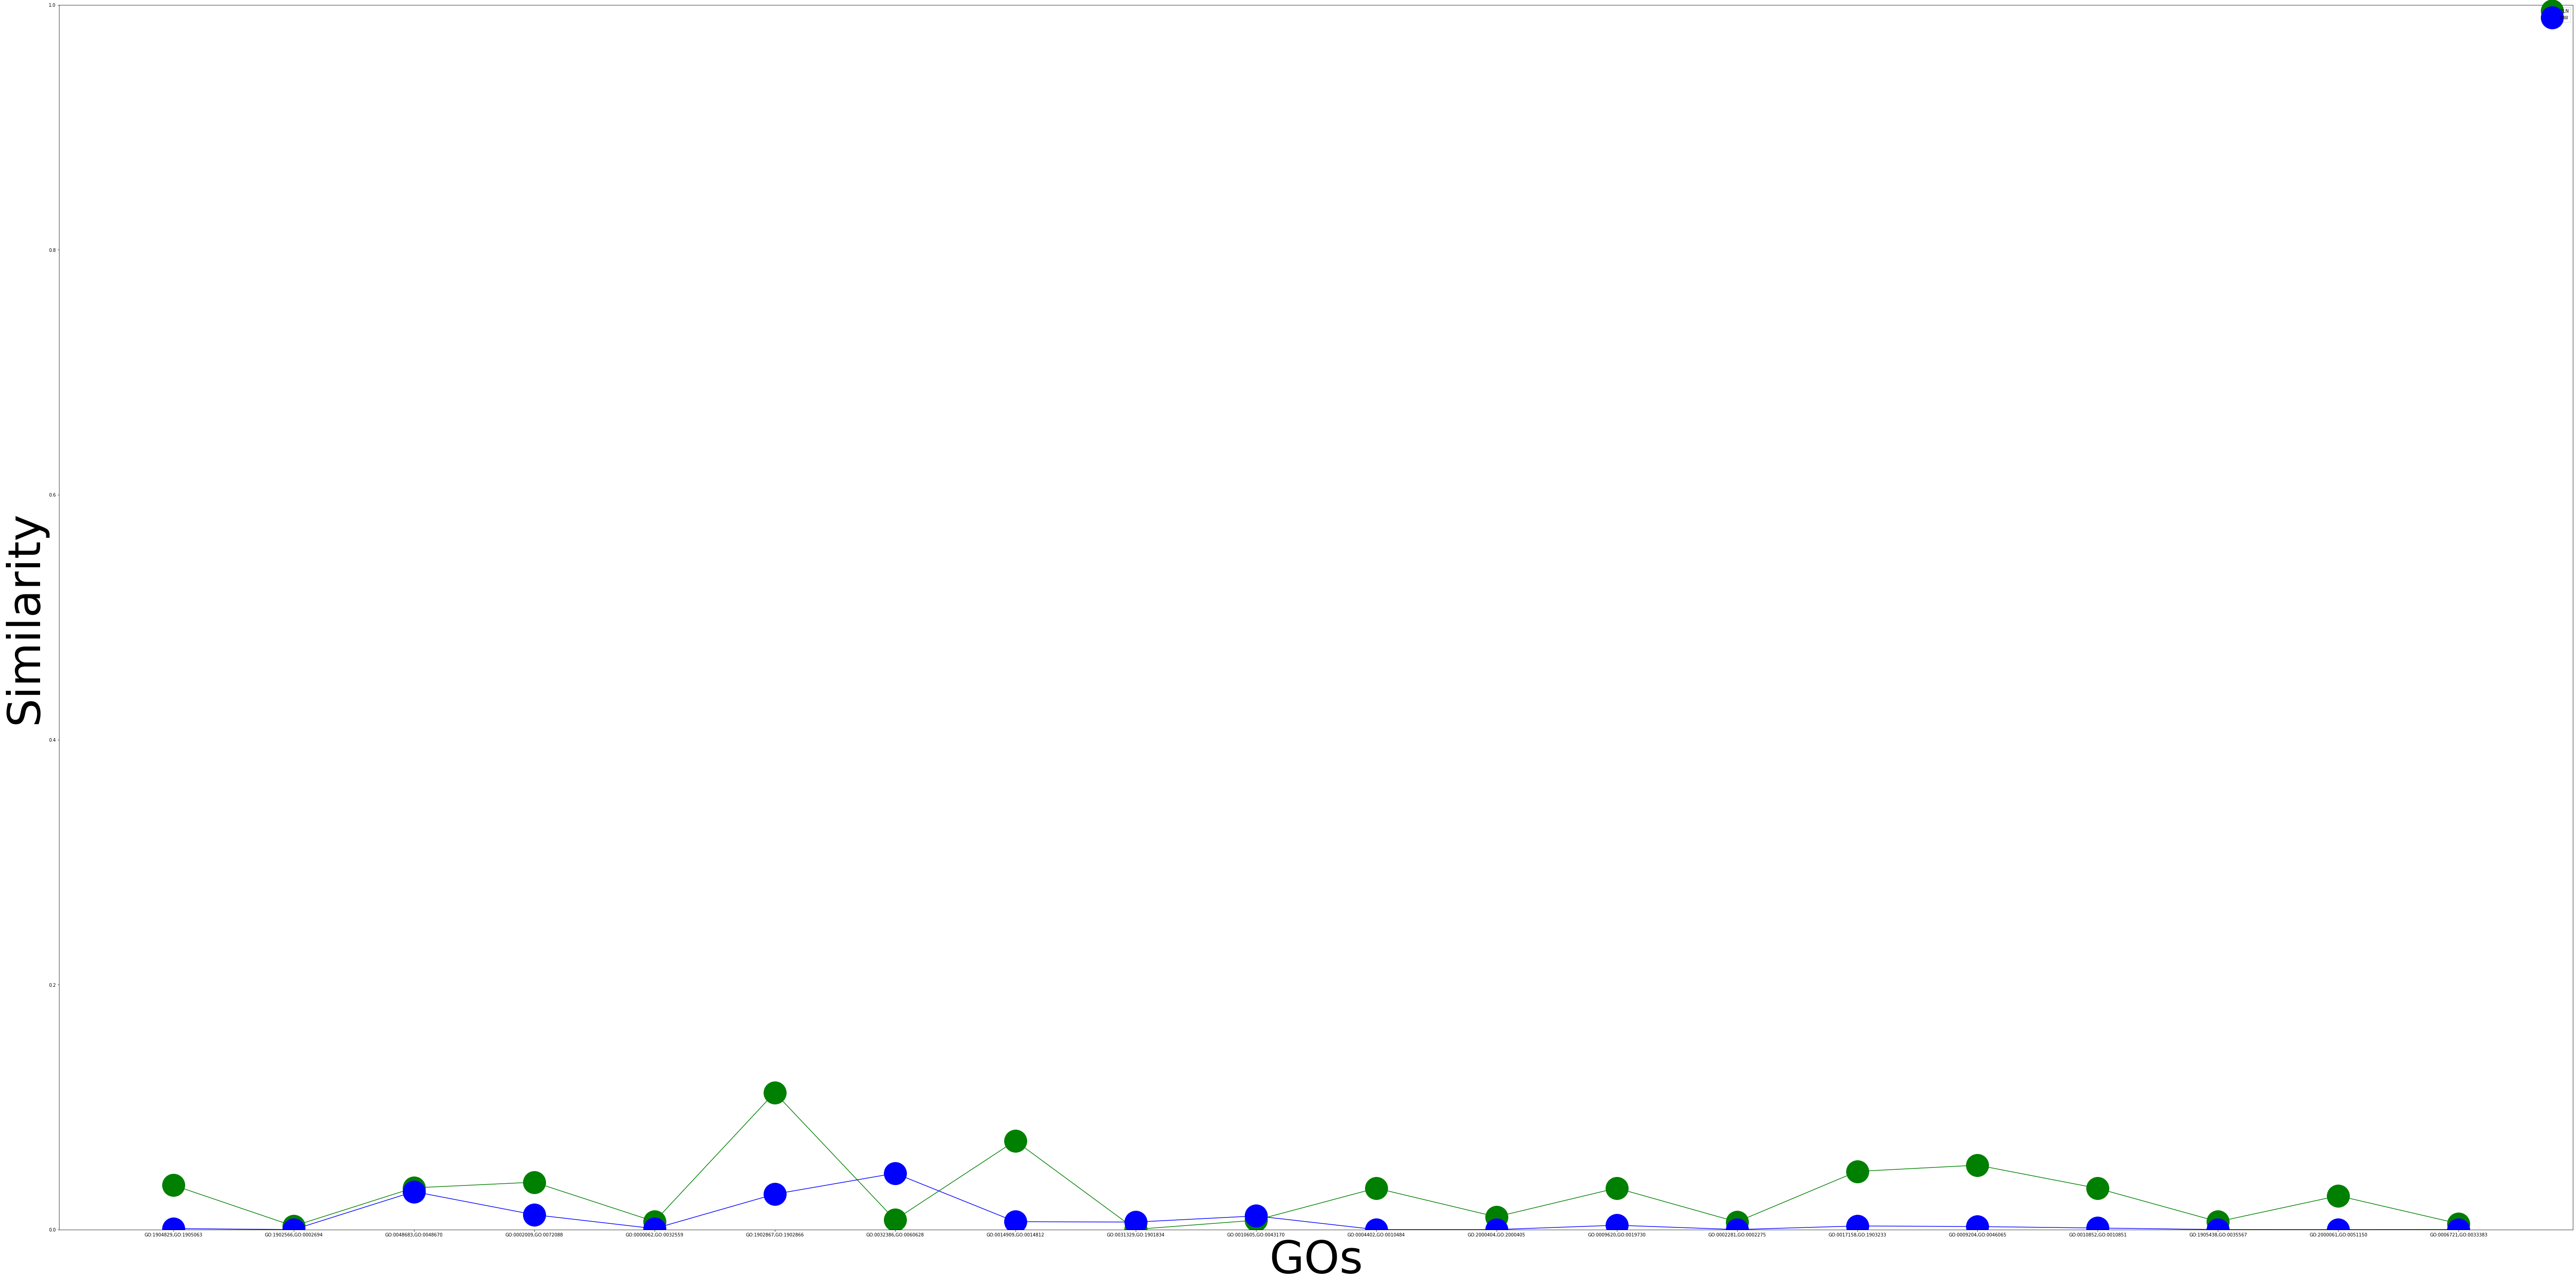

In [96]:
# PLN vs DW similarity values comparison (Report and Plot)

import numpy as np
import matplotlib.pyplot as plt

# Read results
# f1 = open("reasoning-bio-as-xp/pln_results.txt", "r")
# f2 = open("reasoning-bio-as-xp/dw_results.txt", "r")
f1 = open("reasoning-bio-as-xp/pln_results_all.txt", "r")
f2 = open("reasoning-bio-as-xp/dw_results_all.txt", "r")
lines1 = f1.readlines()
lines2 = f2.readlines()
f1.close()
f2.close()

# Populate
gos = []
data_pln = []
data_dw = []
data_pln_default_stv = 0
for line in lines1:
    e = line.split(",")
    v = float(e[2].strip())
    data_pln.append(v)
    if v == 0:
        data_pln_default_stv = data_pln_default_stv + 1
    gos.append(e[0] + "," + e[1])
for line in lines2:
    e = line.split(",")
    data_dw.append(float(e[2].strip()))
# print(gos)
# print(data_pln)
# print(data_dw)

# See which matches which doesn't
match_gos = []
match_data_pln = []
match_data_dw = []
no_match_gos = []
no_match_data_pln = []
no_match_data_dw = []
margin = 0.1
i = 0
while (i < len(gos)):
    if abs(data_pln[i] - data_dw[i]) < margin:
    # if abs(data_pln[i] - data_dw[i]) < margin and data_pln[i] > 0:
        match_gos.append(gos[i])
        match_data_pln.append(data_pln[i])
        match_data_dw.append(data_dw[i])
    else:
        no_match_gos.append(gos[i])
        no_match_data_pln.append(data_pln[i])
        no_match_data_dw.append(data_dw[i])
    i = i + 1

print("Number of GO pairs in experiment = {}".format(len(gos)))
print("Number of matches = {} ({:.2f}%)".format(len(match_gos), ((len(match_gos)/len(gos))*100)))
# print("Number of un-matches = {}".format(len(no_match_gos)))
print("Number of PLN IntensionalSimilarityLinks with default (stv 1 0) = {}".format(data_pln_default_stv))

# Randomly pick n GOs to show
import random
n = 20
'''
## Randomly pick from all GOs
idx = random.sample(range(len(gos)), n)
selected_gos = [gos[i] for i in idx]
selected_pln = [data_pln[i] for i in idx]
selected_dw = [data_dw[i] for i in idx]
'''
## Randomly pick from matched GOs
idx = random.sample(range(len(match_gos)), n)
selected_gos = [match_gos[i] for i in idx]
selected_pln = [match_data_pln[i] for i in idx]
selected_dw = [match_data_dw[i] for i in idx]
'''
## Randomly pick from unmatched GOs
idx = random.sample(range(len(no_match_gos)), n)
selected_gos = [no_match_gos[i] for i in idx]
selected_pln = [no_match_data_pln[i] for i in idx]
selected_dw = [no_match_data_dw[i] for i in idx]
'''
# print(selected_gos)
# print(selected_pln)
# print(selected_dw)

# Plot
ms=50
lfs=100
plt.plot(selected_gos, selected_pln, 'go-', markersize=ms, label='PLN')
plt.plot(selected_gos, selected_dw, 'bo-', markersize=ms, label='DW')
plt.xlabel('GOs', fontsize=lfs)
plt.ylabel('Similarity', fontsize=lfs)
plt.legend(loc='best')
plt.ylim(0, 1)
plt.show()